<a href="https://colab.research.google.com/github/CarlosARossi/dataScienceCoder/blob/main/Desafio_CrossValidation_Carlos_Rossi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Algoritmo de Machine Learning

## Importación de librerias y datasets

### Librerías

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats as stats
from scipy.stats import linregress

import folium
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import learning_curve
import matplotlib.ticker as ticker
from wordcloud import WordCloud

### Dataset

En este proyecto se analizará el conjunto de datos [Global Salary DataSet 2022](https://www.kaggle.com/datasets/ricardoaugas/salary-transparency-dataset-2022). Los datos provienen de una hoja de cálculo de Google que se hizo viral tras ser compartida en LinkedIn por Christen Nino De Guzman, Program Manager en Google. Más de 58.000 personas compartieron sus salarios de forma anónima a través de un formulario de Google.

Debido al alto número de accesos, la hoja de cálculo se volvió lenta y se bloqueaba con frecuencia. Es por esto que alguien la descargo, realizó una limpieza y organización para obtener una visualización amigable. El  conjunto de datos nos proporciona información sobre 32.562 trabajos en 56 países y 15.096 empresas, y se encuentra alojado en Kaggle.



In [2]:
url = 'https://raw.githubusercontent.com/CarlosARossi/dataScienceCoder/main/Datasets/Salary_Data_2022_REV15_2.csv'
salaries = pd.read_csv(url)
salaries

,ID,Timestamp,Age.Range,Years.of.Experience,Industry,Job.Title,Company.Name,Education,Location,Country,...,Currency,Maternity.Paternity.Months,Sick.Days,Office.Days,Open.To.Discuss.Salary,How.many.months.Maternity.or.Paternity.does.your.company.offer.,Gender,X,Diverse.Identity..Optional.,Description
0,1,12/8/2021 3:05,18-21,3.0,GAMING,STREAMER,TWITCH,None,LOS ANGELES CA,US,...,USD,NaN,NaN,NaN,No,as much as i want,Male,NaN,NaN,TWITCH
1,2,12/9/2021 15:49,30-33,5.0,HEALTHCARE,AESTHETIC NURSE PRACTITIONER/BUSINESS OWNER,AESTHETIC CLINIC,Master's Degree,WINNIPEG,CANADA,...,CAD,NaN,NaN,5.0,Yes,NaN,Male,NaN,NaN,AESTHETIC CLINIC
2,3,12/8/2021 2:16,18-21,1.0,ONLINE ARCADE,OWNER,RUST CLASH,High School/GED,SAN DIEGO,US,...,USD,NaN,7.0,NaN,Yes,NaN,Male,NaN,NaN,RUST CLASH
3,4,12/8/2021 5:15,18-21,2.0,CRYPTO,HEAD OF MARKETING,REDACTED,Some College,"TAMPA, FL",US,...,USD,NaN,NaN,NaN,Yes,Not sure,Male,NaN,NaN,REDACTED
4,5,12/8/2021 14:16,34-37,13.0,WINDOW COVERINGS,OWNER,CAROLINA BLIND CRAFTERS,Bachelor's Degree,"CHARLOTTE, NC",US,...,USD,NaN,NaN,3.0,No,None,Female,NaN,NaN,CAROLINA BLIND CRAFTERS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32565,32566,1/7/2022 2:27,30-33,9.0,BEAUTY,SOCIAL MEDIA DIRECTOR,UNILEVER,Bachelor's Degree,"LOS ANGELES, CA",US,...,USD,NaN,NaN,2.0,NaN,NaN,Female,NaN,NaN,UNILEVER
32566,32567,1/7/2022 6:09,34-37,14.0,RETAIL,SENIOR MANAGER,RRL,Master's Degree,MUMBAI,INDIA,...,INR,20,7.0,5.0,No,6,Male,NaN,NaN,RRL
32567,32568,1/7/2022 12:38,30-33,5.0,TECHNOLOGY,MARKETING MANAGER,SIEMENS,Master's Degree,LONDON,UK,...,GBP,NaN,8.0,2.0,No,12,Female,NaN,NaN,SIEMENS
32568,32569,1/7/2022 12:40,26-29,4.0,MATERIAL HANDLING,SOLUTIONS CONSULTANT,DEMATIC,Bachelor's Degree,"GRAND RAPIDS, MI",US,...,USD,NaN,NaN,NaN,Yes,NaN,Male,NaN,Hispanic,DEMATIC


In [3]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32570 entries, 0 to 32569
Data columns (total 24 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   ID                                                               32570 non-null  int64  
 1   Timestamp                                                        32570 non-null  object 
 2   Age.Range                                                        32549 non-null  object 
 3   Years.of.Experience                                              32053 non-null  float64
 4   Industry                                                         32355 non-null  object 
 5   Job.Title                                                        32566 non-null  object 
 6   Company.Name                                                     32568 non-null  object 
 7   Education                               

Al realizar un análisis inicial del conjunto de datos original [Salary_Data_2022_REV15_2](https://www.kaggle.com/datasets/ricardoaugas/salary-transparency-dataset-2022), se observa que los datos provienen de diversas fuentes y países, cada uno con su propia moneda y forma de expresar el salario. Por lo tanto, será necesario agregar información adicional al conjunto de datos para estandarizar la moneda y el período salarial en una única forma de representación.

##Análisis Exploratorio de Datos (EDA)

###Agregado de columna **Exchange.rate.to.USD**

Se realizó una búsqueda de las tasas de conversión a USD para las diferentes monedas identificadas en la columna **Currency** del conjunto de datos original, tomando como referencia la fecha del 20/12/2021. Esta fecha se seleccionó por estar en el punto medio del período en el que se recopiló la información del dataset.

Utilizando la información obtenida, se generó una lista de tuplas y posteriormente se creó un diccionario mediante el uso de la función dict().

Luego, basandose en la columna **Currency** como clave en el diccionario y con el método map de pandas se asignaron los valores correspondientes de la tasa de conversión a USD al dataset **salaries** en la nueva columna llamada **Exchange.rate.to.USD**

In [4]:
exchange_rates = [
    ('AED', 3.67235),
    ('ARS', 176.55000),
    ('AUD', 1.40301),
    ('BHD', 0.37463),
    ('CAD', 1.28848),
    ('CNY', 6.37440),
    ('COP', 3966.91000),
    ('DKK', 6.61604),
    ('EGP', 15.71170),
    ('EUR', 0.88989),
    ('GBP', 0.75534),
    ('GHS', 6.11800),
    ('HKD', 7.80164),
    ('HUF', 326.57800),
    ('ILS', 3.11920),
    ('INR', 75.87400),
    ('KRW', 1186.63000),
    ('MXN', 20.79900),
    ('NGN', 409.76500),
    ('RON', 4.39980),
    ('RSD', 104.37400),
    ('SAR', 3.74524),
    ('SEK', 9.12911),
    ('SGD', 1.36656),
    ('TRY', 16.39630),
    ('USD', 1.000),
    ('ZAR', 15.88200)
]

# Creación de un diccionario a partir de la lista de tasas de cambio
exchange_rates_dict = dict(exchange_rates)

# Agregado de la columna "Exchange.rate.to.USD" al dataset "salaries"
salaries['Exchange.rate.to.USD'] = salaries['Currency'].map(exchange_rates_dict)


###Agregado de columna **SalaryUSD**

Para estandarizar los salarios en una misma moneda (USD), se realizó una división de los valores de la columna **Salary** por los correspondientes valores de la columna **Exchange.rate.to.USD**. El resultado se almacenó en una nueva columna denominada **SalaryUSD**.

El fin de este proceso es garantizar que todos los salarios del dataset estén representados de manera uniforme, lo que facilitará la comparación y el análisis de los datos.

In [5]:
# Agregado de la columna "SalaryUSD" al dataset "salaries"
salaries['SalaryUSD'] = salaries['Salary'] / salaries['Exchange.rate.to.USD']

###Agregado de columna **Salary.Period**

Tras observar valores salariales promedio inusualmente altos en la columna **SalaryUSD** en algunos países, se determinó que esto se debía a la utilización de diferentes períodos salariales en cada país. Con el fin de mejorar el análisis, se identificó qué países utilizaban un período anual y se creó un  array con dichos países. Aquellos que no se encontraban en el array fueron marcados como salarios mensuales.

Esta nueva identificación del salario se agregó en la columna **Salary.Period** y  permitirá una comparación más precisa y consistente de los salarios entre los países en el conjunto de datos.

In [6]:
countries_with_annual_period = ['AFGHANISTAN', 'AMERICAN SAMOA', 'AUSTRALIA', 'BAHRAIN', 'BELGIUM', 'CANADA', 'CARMEL', 'CHINA', 'CZECH REPUBLIC', 'DEVON', 'ESTONIA', 'FAYETTE', 'FRANCE', 'GERMANY', 'HONDURAS', 'INDONESIA', 'ISRAEL', 'ITALY', 'JAPAN', 'LEBANON', 'LUXEMBOURG', 'MARICOPA', 'MEXICO', 'MOROCCO', 'NORTH MACEDONIA', 'PANAMA', 'PERU', 'PORTUGAL', 'QATAR', 'SAUDI ARABIA', 'SINGAPORE', 'SOUTH AFRICA', 'SPAIN', 'TARRANT', 'UK', 'UNITED ARAB EMIRATES', 'US', 'VENTURA']

# Agregado de la columna "Salary.Period" al dataset "salaries"
salaries['Salary.Period'] = salaries['Country'].apply(lambda x: 'Annual' if x in countries_with_annual_period else 'Monthly')

###Agregado de columna **Monthly.SalaryUSD**


Tomando como base la columna **Salary.Period**, se realizó una operación de transformación en los registros que tenían el valor "Annual" en la columna. Se dividió el valor de la columna **SalaryUSD** por 12 y el resultado se almacenó en una nueva columna llamada **Monthly.SalaryUSD**. Por otro lado, los registros que tenían el valor "Monthly" en la columna **Salary.Period** se mantuvieron sin cambios y se copiaron directamente en la columna **Monthly.SalaryUSD**.

Esta transformación permitió estandarizar todos los salarios en una representación mensual para facilitar el análisis comparativo.

In [7]:
salaries['Monthly.SalaryUSD'] = salaries.apply(lambda row: row['SalaryUSD'] / 12 if row['Salary.Period'] == 'Annual' else row['SalaryUSD'], axis=1)

###Limpieza de salarios con valor 0

Debido a la presencia de valores iguales a 0 en la columna "Monthly.SalaryUSD" del dataset, se tomó la decisión de eliminar esas filas con el fin de reducir el error al calcular el promedio.

Al eliminar estas líneas, se garantiza que el análisis se base en datos más precisos y representativos, evitando la distorsión que podría ocasionar la inclusión de salarios con valor cero.

In [8]:
# Contar los valores igual a 0 en la columna Monthly.SalaryUSD
count_zero = (salaries['Monthly.SalaryUSD'] == 0).sum()

print("Cantidad de valores igual a 0 en Monthly.SalaryUSD:", count_zero)


Cantidad de valores igual a 0 en Monthly.SalaryUSD: 808


In [9]:
# Filtrar las filas que tienen Monthly.SalaryUSD diferente de 0
salaries_filtered = salaries[salaries['Monthly.SalaryUSD'] != 0]

# Contar los valores igual a 0 en la columna Monthly.SalaryUSD
count_zero = (salaries_filtered['Monthly.SalaryUSD'] == 0).sum()

print("Cantidad de valores igual a 0 en Monthly.SalaryUSD:", count_zero)


Cantidad de valores igual a 0 en Monthly.SalaryUSD: 0


###Eliminado de columnas con datos no significativos



In [10]:
# Listar las columnas del dataset
columns = salaries_filtered.columns

# Imprimir las columnas
print(columns)

Index(['ID', 'Timestamp', 'Age.Range', 'Years.of.Experience', 'Industry',
       'Job.Title', 'Company.Name', 'Education', 'Location', 'Country',
       'Salary', 'Annual.Bonus', 'Annual.Average.of.RSUs', 'Signing.Bonus',
       'Currency', 'Maternity.Paternity.Months', 'Sick.Days', 'Office.Days',
       'Open.To.Discuss.Salary',
       'How.many.months.Maternity.or.Paternity.does.your.company.offer.',
       'Gender', 'X', 'Diverse.Identity..Optional.', 'Description',
       'Exchange.rate.to.USD', 'SalaryUSD', 'Salary.Period',
       'Monthly.SalaryUSD'],
      dtype='object')


In [11]:
# Selecciono las columnas deseadas
columns = ['Age.Range',
           'Years.of.Experience',
           'Industry',
           'Job.Title',
           'Company.Name',
           'Education',
           'Country',
           'Gender',
           'Monthly.SalaryUSD',
           'Salary.Period']

salaries_filtered = salaries_filtered[columns]

salaries_filtered

,Age.Range,Years.of.Experience,Industry,Job.Title,Company.Name,Education,Country,Gender,Monthly.SalaryUSD,Salary.Period
0,18-21,3.0,GAMING,STREAMER,TWITCH,None,US,Male,40833.333333,Annual
1,30-33,5.0,HEALTHCARE,AESTHETIC NURSE PRACTITIONER/BUSINESS OWNER,AESTHETIC CLINIC,Master's Degree,CANADA,Male,31691.088207,Annual
2,18-21,1.0,ONLINE ARCADE,OWNER,RUST CLASH,High School/GED,US,Male,40000.000000,Annual
3,18-21,2.0,CRYPTO,HEAD OF MARKETING,REDACTED,Some College,US,Male,40000.000000,Annual
4,34-37,13.0,WINDOW COVERINGS,OWNER,CAROLINA BLIND CRAFTERS,Bachelor's Degree,US,Female,40000.000000,Annual
...,...,...,...,...,...,...,...,...,...,...
31757,30-33,5.0,ECOMMERCE,DESIGN MANAGER,MIS,Bachelor's Degree,INDIA,Male,0.092258,Monthly
31758,22-25,5.0,HOTEL/RESTAURANT,MANAGER/CHEF,CASA BAROLO,Bachelor's Degree,ROMANIA,Female,1.363698,Monthly
31759,58+,NaN,SPORTS,ANALYST,ESPN,None,US,Female,0.083333,Annual
32568,26-29,4.0,MATERIAL HANDLING,SOLUTIONS CONSULTANT,DEMATIC,Bachelor's Degree,US,Male,9166.666667,Annual


###Conclusión EDA

En este proyecto, se agregaron columnas de conversión de moneda y estandarización salarial al dataset original. Además, se identificaron los países con períodos salariales anuales y se generaron columnas correspondientes. También se eliminaron los salarios con valor 0 para mejorar la precisión. Estos pasos nos permitirán preparar el modelo y cumplir con el objetivo de proporcionar información sobre la banda salarial basada en datos personales.

Valores mensuales y anuales antes y despues del filtrado

In [12]:
count_salary_period_1 = salaries['Salary.Period'].value_counts()
count_salary_period_2 = salaries_filtered['Salary.Period'].value_counts()

monthly_count_1 = count_salary_period_1['Monthly']
annual_count_1 = count_salary_period_1['Annual']

monthly_count_2 = count_salary_period_2['Monthly']
annual_count_2 = count_salary_period_2['Annual']

print(f"Valores antes del filtrado: \n Monthly: {monthly_count_1} - Annual: {annual_count_1}")
print(f"Valores luego del filtrado: \n Monthly: {monthly_count_2} - Annual: {annual_count_2}")

Valores antes del filtrado: 
 Monthly: 75 - Annual: 32495
Valores luego del filtrado: 
 Monthly: 47 - Annual: 31715


##Data Wrangling

###Valores Faltante

In [13]:
# Controlo cuantos NaN hay en las columnas de mi dataset
for column in columns:
    nan_count = salaries_filtered[column].isnull().sum()
    print(f"{column} tiene {nan_count} NaN")

Age.Range tiene 20 NaN
Years.of.Experience tiene 502 NaN
Industry tiene 204 NaN
Job.Title tiene 4 NaN
Company.Name tiene 2 NaN
Education tiene 0 NaN
Country tiene 0 NaN
Gender tiene 0 NaN
Monthly.SalaryUSD tiene 0 NaN
Salary.Period tiene 0 NaN


Se realizará la eliminación de filas que contengan valores faltantes en las columnas elegidas en el punto anterior.

Esto se realizará por las siguientes razones:
1. **Integridad de los datos:** Al eliminar las filas con valores faltantes, garantizaremos que los datos restantes sean consistentes y confiables, evitando sesgos o distorsiones en los análisis y modelos posteriores.

2. **Simplificación del análisis:** Se evitara tener que lidiar con técnicas de imputación o llenado de datos faltantes, lo que simplificará el flujo de trabajo y facilitará el análisis exploratorio y los cálculos posteriores.

3. **Enfoque en variables clave:** Al seleccionar solo las columnas clave sin valores faltantes, podremos centrarnos en las variables más importantes para el estudio, lo que te brindará una visión más precisa y significativa de los factores que influyen en el salario mensual.

In [14]:
# Seleccionar las columnas deseadas
columns_to_check = ['Age.Range',
                    'Years.of.Experience',
                    'Industry',
                    'Job.Title',
                    'Company.Name',
                    ]

salaries_without_NaN = salaries_filtered.dropna(subset=columns_to_check)

salaries_without_NaN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31043 entries, 0 to 32569
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age.Range            31043 non-null  object 
 1   Years.of.Experience  31043 non-null  float64
 2   Industry             31043 non-null  object 
 3   Job.Title            31043 non-null  object 
 4   Company.Name         31043 non-null  object 
 5   Education            31043 non-null  object 
 6   Country              31043 non-null  object 
 7   Gender               31043 non-null  object 
 8   Monthly.SalaryUSD    31043 non-null  float64
 9   Salary.Period        31043 non-null  object 
dtypes: float64(2), object(8)
memory usage: 2.6+ MB


###Reducción de Instancias



Se llevará a cabo un análisis detallado de las siguientes columnas:
1. Age.Range
2. Years.of.Experience
3. Industry
4. Job.Title
5. Education
6. Country
7. Gender

Estó se realizará para comprender mejor los datos relacionados con la demografía, la experiencia laboral, la industria, el título laboral, el nivel educativo, el país y el género de los individuos en el conjunto de datos. Esta exploración permitirá obtener información relevante para el posterior modelado y predicción del salario.

Una vez realizado el análisis, se procederá a reducir las instancias del conjunto de datos, seleccionando un subconjunto de filas basado en criterios relevantes. La reducción de instancias nos permitirá enfocarnos en las características clave y construir un modelo más preciso y eficaz para predecir el salario en función de las variables seleccionadas.

####Rango de edades [Age.Range]

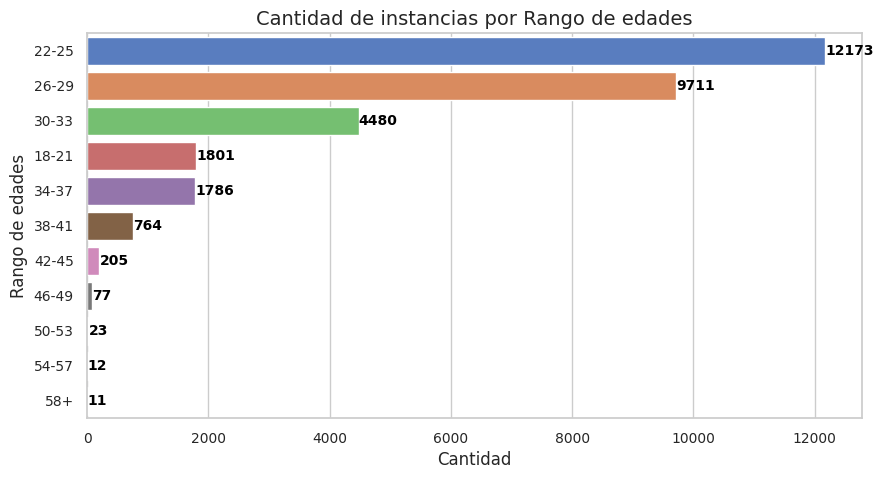

In [15]:
# Contar las instancias únicas de Age.Range
age_range_counts = salaries_without_NaN['Age.Range'].value_counts()

# Ordenar en orden descendente
age_range_counts = age_range_counts.sort_values(ascending=False)

# Establecer el estilo de Seaborn
sns.set(style="whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=age_range_counts.values, y=age_range_counts.index, palette="muted")

# Agregar el número de cuentas en cada barra
for i, count in enumerate(age_range_counts):
    ax.text(count, i, str(count), ha='left', va='center', color='black', weight='bold', fontsize=10)

# Configurar los títulos y etiquetas de los ejes
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Rango de edades', fontsize=12)
plt.title('Cantidad de instancias por Rango de edades', fontsize=14)

# Cambiar el tamaño de las marcas de los ejes X e Y
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

Al tener 11 variables en 'Age.Range', se podrían generar 11 nuevas columnas binarias correspondientes a cada rango de edad (One Hot Encoding), lo que permitirá utilizar estas variables en los modelos de aprendizaje sin problemas.

####Años de experiencia [Years.of.Experience]

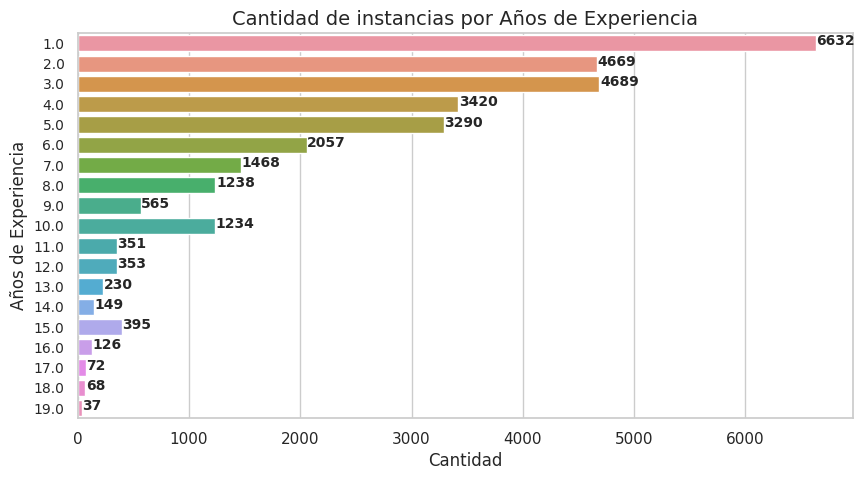

In [16]:
# Establecer el estilo de Seaborn
sns.set(style="whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(10, 5))
ax = sns.countplot(y='Years.of.Experience', data=salaries_without_NaN)

plt.yticks(fontsize=10)

# Agregar el número de cuentas en cada barra con tamaño de letra personalizado
for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width()+5, p.get_y()+0.5), fontsize=10, weight='bold')

# Configurar los títulos y etiquetas de los ejes
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Años de Experiencia', fontsize=12)
plt.title('Cantidad de instancias por Años de Experiencia', fontsize=14)
plt.show()

La columna 'Years.of.Experience' es una variable ordinal, lo que implica que tiene un orden inherente y representación numérica que refleja el nivel de experiencia.

####Industrias [Industry]

Debido a la gran cantidad de instancias únicas en la columna 'Industry', se aplicará un enfoque de agrupación utilizando coincidencia de cadenas y expresiones regulares.

El objetivo es reducir la diversidad de categorías, creando grupos más amplios y generalizados.

Esto facilitará el análisis y la interpretación de los datos al identificar palabras clave y términos relacionados en las categorías existentes.

Al agrupar las industrias de manera más general, se obtendrá una mejor comprensión de los patrones y tendencias generales en los datos.

In [17]:
# Calcular la frecuencia de las categorías en Industry
industry_counts = salaries_without_NaN['Industry'].value_counts()

print("Cantidad de Industrias:", len(salaries_without_NaN['Industry'].unique()))
industry_counts

Cantidad de Industrias: 5550


TECH                              3288
HEALTHCARE                        1603
FINANCE                           1073
EDUCATION                          812
CONSULTING                         739
                                  ... 
DIGTECHAL TECH                       1
PACKAGING / MANUFACTURING            1
PAID DIGTECHAL MEDIA MARKETING       1
GLASS                                1
HOTEL/RESTAURANT                     1
Name: Industry, Length: 5550, dtype: int64

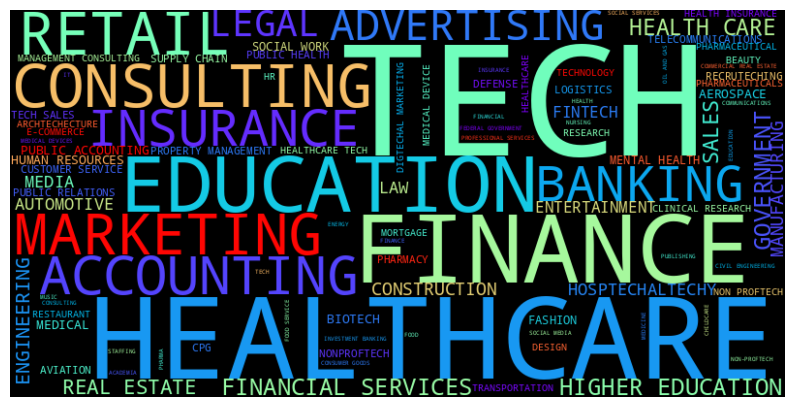

In [18]:
# Crea el objeto WordCloud con las palabras y sus respectivas frecuencias
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='rainbow',
                      contour_color='black', contour_width=1, max_words=100).generate_from_frequencies(industry_counts)

# Configura el gráfico
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Muestra el gráfico
plt.show()

Se agruparán las industrias basándose en palabras clave obtenidas en el gráfico anterior del tipo Word Cloud. Esto mejorará la interpretación y análisis al agrupar categorías más comunes.

In [19]:
# Crear una copia del dataset anterior
salaries_re_industry = salaries_without_NaN.copy()

groupings = {
    'Technology': ['tech', 'digital', 'software', 'hardware', 'IT', 'internet', 'engineering'],
    'Healthcare': ['health', 'medical', 'pharmaceutical', 'medicine', 'physician', 'nursing', 'dentistry', 'doctor', 'pharmacy', 'nurse', 'dental', 'clinical', 'social work','pharma'],
    'Retail': ['retail', 'shopping', 'e-commerce', 'brick and mortar', 'ecommerce', 'sales','grocery'],
    'Manufacturing': ['manufacturing', 'production', 'factory', 'assembly','CPG'],
    'Finance': ['finance', 'banking', 'investments', 'accounting', 'financial', 'insurance', 'mortgage'],
    'Education & Research': ['education', 'learning', 'academia', 'teaching', 'research'],
    'Transportation': ['transportation', 'logistics', 'shipping', 'delivery','transport'],
    'Food & Beverage': ['food', 'beverage', 'restaurant', 'catering'],
    'Hospitality': ['hospitality', 'tourism', 'hotel', 'travel'],
    'Entertainment': ['entertainment', 'media', 'film', 'music', 'creative', 'content creator', 'TV'],
    'Energy': ['energy', 'utilities', 'renewable', 'power','oil','gas'],
    'Construction': ['construction', 'building', 'architecture', 'contracting'],
    'Consulting': ['consulting', 'advisory', 'strategy', 'management'],
    'Real Estate': ['real estate', 'property', 'housing', 'development'],
    'Agriculture': ['agriculture', 'farming', 'agribusiness', 'crop'],
    'Government': ['government', 'public sector', 'civil service', 'administration', 'defense'],
    'Administrative': ['administrative', 'human resources', 'social work','customer service', 'HR','human services','social services'],
    'Non-profit': ['non-profit', 'charity', 'NGO', 'volunteer'],
    'Media': ['media', 'communication', 'journalism', 'publishing', 'public relations'],
    'Automotive': ['automotive', 'vehicles', 'car', 'automobile'],
    'Aerospace': ['aerospace', 'aviation', 'aeronautics', 'space'],
    'Sports': ['sports', 'athletics', 'fitness', 'recreation','sport'],
    'Legal Services': ['legal', 'law', 'attorney', 'legal services'],
    'Marketing': ['marketing', 'advertising', 'content marketing', 'digital marketing'],
    'Fashion & Beauty': ['fashion', 'clothing', 'apparel', 'design','beauty','cosmetics'],
    'Data & AI': ['data', 'AI', 'big data', 'data science', 'analytics'],
    'Pets': ['pets', 'animals', 'pet care', 'veterinary', 'pet', 'animal', 'vet'],
    'Gaming':['gaming', 'game', 'games', 'video game', 'arcade','esport']
}



# Función para agrupar categorías basadas en patrones de coincidencia
def group_industry(category):
    for group, patterns in groupings.items():
        for pattern in patterns:
            if re.search(pattern, category, re.IGNORECASE):
                return group
    return 'Others'

# Aplicar la función de agrupación a la columna 'Industry' y crear una nueva columna 'GroupedIndustry'
salaries_re_industry['GroupedIndustry'] = salaries_re_industry['Industry'].apply(group_industry)


# Calcular la frecuencia de las categorías en GroupedIndustry
industry_counts = salaries_re_industry['GroupedIndustry'].value_counts()
with pd.option_context('display.max_rows', None):
    print(industry_counts)


print("Cantidad de Industrias Agrupadas es:", len(salaries_re_industry['GroupedIndustry'].unique()))


Technology              7519
Healthcare              4068
Finance                 4061
Others                  2695
Education & Research    1615
Retail                  1530
Marketing               1323
Consulting              1255
Entertainment            815
Government               729
Legal Services           575
Manufacturing            498
Administrative           497
Fashion & Beauty         494
Media                    431
Real Estate              413
Food & Beverage          405
Automotive               399
Construction             340
Data & AI                295
Aerospace                290
Transportation           265
Energy                   241
Sports                    84
Hospitality               74
Gaming                    51
Agriculture               48
Pets                      33
Name: GroupedIndustry, dtype: int64
Cantidad de Industrias Agrupadas es: 28


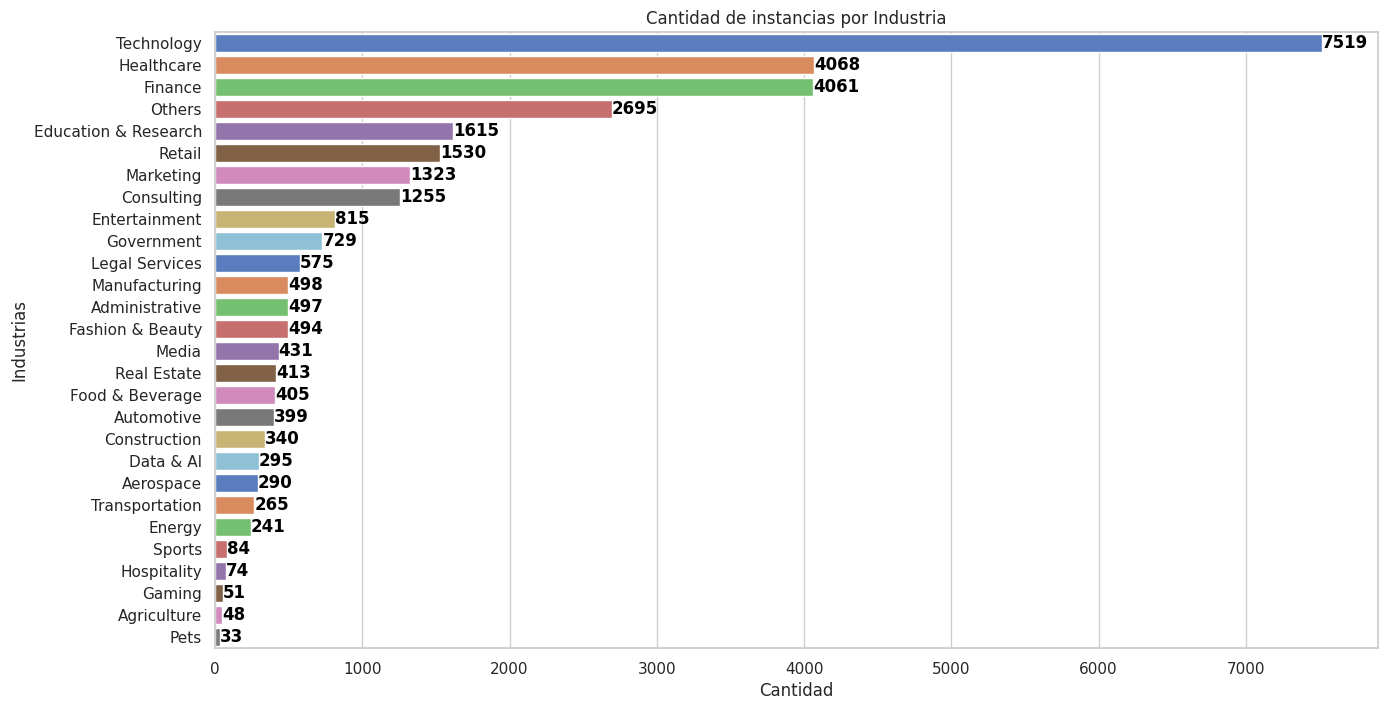

In [20]:
# Contar las instancias únicas de Industry
industry_counts = salaries_re_industry['GroupedIndustry'].value_counts()

# Ordenar en orden descendente
industry_counts = industry_counts.sort_values(ascending=False)

# Establecer el estilo de Seaborn
sns.set(style="whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=industry_counts.values, y=industry_counts.index, palette="muted")

# Agregar el número de cuentas en cada barra
for i, count in enumerate(industry_counts):
    ax.text(count, i, str(count), ha='left', va='center', color='black', weight='bold')

# Configurar los títulos y etiquetas de los ejes
plt.xlabel('Cantidad')
plt.ylabel('Industrias')
plt.title('Cantidad de instancias por Industria')

plt.show()

In [21]:
salaries_re_industry.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31043 entries, 0 to 32569
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age.Range            31043 non-null  object 
 1   Years.of.Experience  31043 non-null  float64
 2   Industry             31043 non-null  object 
 3   Job.Title            31043 non-null  object 
 4   Company.Name         31043 non-null  object 
 5   Education            31043 non-null  object 
 6   Country              31043 non-null  object 
 7   Gender               31043 non-null  object 
 8   Monthly.SalaryUSD    31043 non-null  float64
 9   Salary.Period        31043 non-null  object 
 10  GroupedIndustry      31043 non-null  object 
dtypes: float64(2), object(9)
memory usage: 2.8+ MB


####Puestos de Trabajo [Job.Title]

Se utilizará el mismo enfoque de agrupación por coincidencia de cadenas y expresiones regulares en la columna 'Job.Title'.

Esto permitirá simplificar la gran cantidad de títulos de trabajo únicos y obtener categorías más generales. Al agrupar los títulos de trabajo de esta manera, se facilitará el análisis y la interpretación de los datos, así como la identificación de patrones y tendencias.

Además, este enfoque simplificado será útil para modelar y predecir salarios basados en los títulos de trabajo.

In [22]:
# Calcular la frecuencia de las categorías en Job.Title
job_title_counts = salaries_re_industry['Job.Title'].value_counts()

print("Cantidad de Puestos de trabajo:", len(salaries_re_industry['Job.Title'].unique()))

job_title_counts

Cantidad de Puestos de trabajo: 12340


SOFTWARE ENGINEER                  446
ANALYST                            419
PROJECT MANAGER                    372
ASSOCIATE                          303
ACCOUNT MANAGER                    283
                                  ... 
DIGITAL TECH LEADERSHIP PROGRAM      1
AUDIT & ASSURANCE STAFF              1
ASSISTANT PROJECT ENGINEER           1
APPLICATION EXPERT                   1
MANAGER/CHEF                         1
Name: Job.Title, Length: 12340, dtype: int64

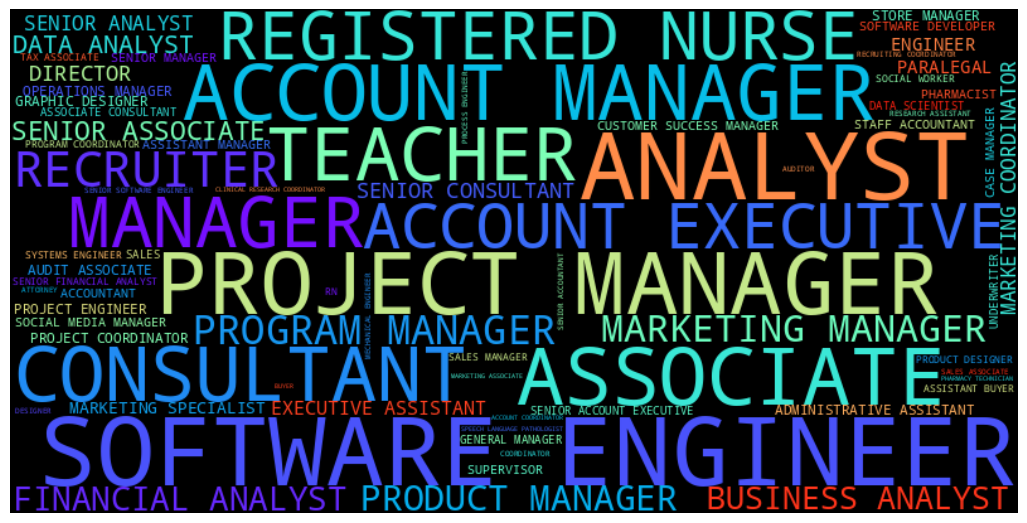

In [23]:
# Crea el objeto WordCloud con las palabras y sus respectivas frecuencias
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='rainbow',
                      contour_color='black', contour_width=1, max_words=75).generate_from_frequencies(job_title_counts)

# Configura el gráfico
plt.figure(figsize=(13, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Muestra el gráfico
plt.show()

Se agruparán los títulos de trabajo basándose en palabras clave obtenidas en el gráfico anterior del tipo Word Cloud y estableciendo un umbral de frecuencia mínima de 50 repeticiones. Esto mejorarà la interpretación y análisis al priorizar categorías más comunes.

In [24]:
# Crear una copia del dataset anterior
salaries_re_jobTitle = salaries_re_industry.copy()

keyword_patterns = {
    'Project/Program Manager': ['project manager', 'project management','project coordinator','Program Manager','PROGRAM COORDINATOR','PROJECT ADMINISTRATOR'],
    'Product Owner/Manager': ['product owner','product manager'],
    'Data Analyst': ['data analyst', 'data analysis'],
    'Data Scientist': ['data scientist','DATA ENGINEER'],
    'Data Engineer': ['DATA ENGINEER'],
    'Financial Analyst': ['financial analyst'],
    'Business Analyst': ['business analyst'],
    'Nurse': ['nurse', 'nursing','cna', 'rn'],
    'Developer': ['developer'],
    'Software Engineer': ['software engineer'],
    'Designer / UX': ['designer','UX'],
    'Teacher': ['teacher'],
    'Social Media Manager': ['Social Media Manager','Social Media'],
    'Consultant': ['consultant'],
    'Account Executive/Manager': ['account executive','account manager','ACCOUNT COORDINATOR'],
    'Director': ['director'],
    'Associate': ['associate'],
    'Assistant': ['assistant'],
    'Store Manager': ['store manager'],
    'Marketing Manager/Coordinator': ['marketing manager','marketing coordinator', 'MARKETING'],
    'Human Resourse / Recruiter': ['HR', 'human resourse','human resourser','recruiter','RECRUITING'],
    'Pharmaceutical': ['PHARMACEUTICAL','PHARMACIST','PHARMACY'],
    'Auditor': ['auditor'],
    'Testing & Quality Assurance': ['QA','test','testing','QUALITY ASSURANCE'],
    'Banker': ['BANKER'],
    'Dentist': ['dental', 'dentist','ORTHODONTIST'],
    'Underwriter': ['UNDERWRITER'],
    'Lawyer': ['law','PARALEGAL','ATTORNEY'],
    'Sales Manager': ['sales manager','sales'],
    'Operations Manager': ['operations manager'],
    'Buyer': ['buyer'],
    'Marketing Specialist': ['MARKETING SPECIALIST'],
    'Accountant': ['ACCOUNTANT'],
    'Therapist': ['THERAPIST'],
    'Researcher': ['researcher','research'],
    'V Level': ['VP', 'VICE PRESIDENT','AVP'],
    'C Level': ['CEO', 'OWNER'],
    'Social Worker': ['SOCIAL WORKER'],
    'Coordinator': ['COORDINATOR'],
    'Supervisor': ['Supervisor'],
    'Engineer': ['engineer'],
    'Specialist': ['SPECIALIST'],
    'Others Analyst': ['Analyst'],
    'Others Managers': ['Manager'],
}


# Función para realizar la agrupación por expresiones regulares y GroupedIndustry
def group_job_title(title, industry):
    if title in keyword_patterns:
        return title  # Si el Job.Title se encuentra en el diccionario, se mantiene el valor original
    else:
        for pattern_title, patterns in keyword_patterns.items():
            for pattern in patterns:
                if re.search(pattern, title, re.IGNORECASE):
                    return pattern_title
    return 'Others'  # Si no coincide con ninguna palabra clave, se mantiene el valor original

# Aplicar la agrupación por expresiones regulares y GroupedIndustry y crear una nueva columna 'GroupedJobTitle'
salaries_re_jobTitle['GroupedJobTitle'] = salaries_re_jobTitle.apply(lambda row: group_job_title(row['Job.Title'], row['GroupedIndustry']), axis=1)


# Calcular la frecuencia de las categorías en GroupedJobTitle
job_title_counts = salaries_re_jobTitle['GroupedJobTitle'].value_counts()
job_title_counts_filtered = job_title_counts[job_title_counts > 0]

with pd.option_context('display.max_rows', None):
    print(job_title_counts_filtered)


print("Cantidad de Puestos de Trabajo Agrupados es:", len(salaries_re_jobTitle['GroupedJobTitle'].unique()))


Others                           6512
Others Managers                  2344
Associate                        1999
Others Analyst                   1902
Assistant                        1400
Engineer                         1333
Consultant                       1141
Specialist                       1140
Project/Program Manager          1125
Nurse                            1108
Marketing Manager/Coordinator    1072
Director                          942
Account Executive/Manager         858
Coordinator                       710
Human Resourse / Recruiter        680
Designer / UX                     675
Sales Manager                     661
Software Engineer                 646
Teacher                           598
Product Owner/Manager             332
Accountant                        320
Supervisor                        303
Researcher                        294
Financial Analyst                 278
Business Analyst                  241
Pharmaceutical                    226
Social Media

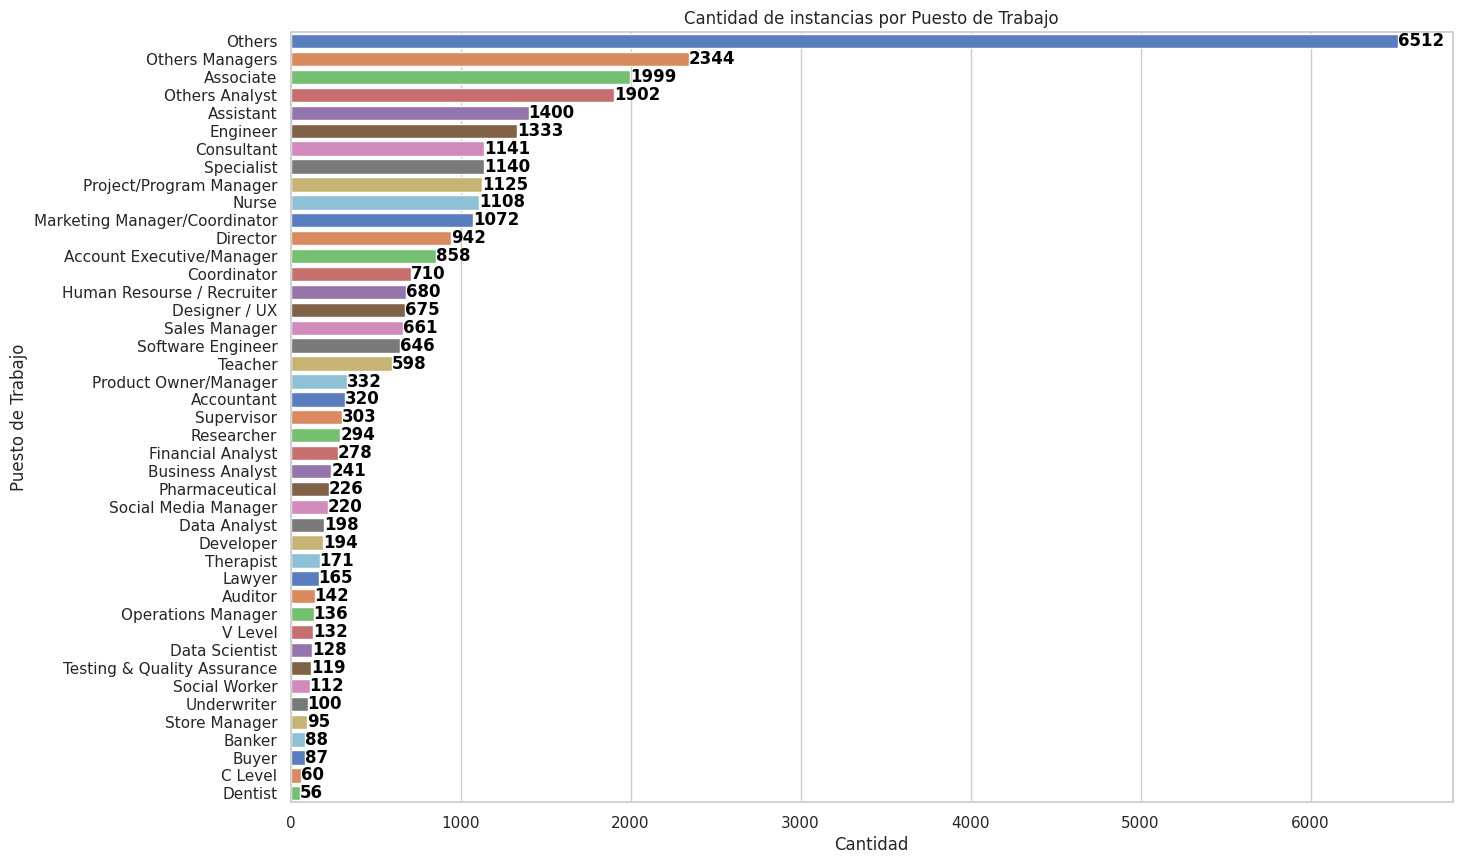

In [25]:
# Ordenar en orden descendente
job_title_counts = job_title_counts.sort_values(ascending=False)

# Establecer el estilo de Seaborn
sns.set(style="whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(15, 10))
ax = sns.barplot(x=job_title_counts.values, y=job_title_counts.index, palette="muted")

# Agregar el número de cuentas en cada barra
for i, count in enumerate(job_title_counts):
    ax.text(count, i, str(count), ha='left', va='center', color='black', weight='bold')

# Configurar los títulos y etiquetas de los ejes
plt.xlabel('Cantidad')
plt.ylabel('Puesto de Trabajo')
plt.title('Cantidad de instancias por Puesto de Trabajo')

plt.show()

####País [Country]

In [26]:
# Crear una copia del dataset anterior
salaries_country = salaries_re_jobTitle.copy()

In [27]:
# Calcular la frecuencia de las categorías en Country
country_counts = salaries_country['Country'].value_counts()

In [28]:
# Calcular el porcentaje acumulado
country_cumsum = country_counts.cumsum() / country_counts.sum()

In [29]:
# Calcular el umbral para agrupar las categorías menos frecuentes
threshold = country_cumsum[country_cumsum > 0.995].index[0]

# Agrupar las categorías menos frecuentes en 'others'
salaries_country.loc[salaries_country['Country'].isin(country_counts[country_counts < country_counts[threshold]].index), 'Country'] = 'OTHERS'

# Verificar los resultados
print("Cantidad de Países:", len(salaries_country['Country'].unique()))

Cantidad de Países: 8


In [30]:
# Reemplaza "US" por "United States" en la columna "Country"
salaries_country['Country'] = salaries_country['Country'].replace('US', 'UNITED STATES')
salaries_country['Country'] = salaries_country['Country'].replace('UK', 'UNITED KINGDOM')

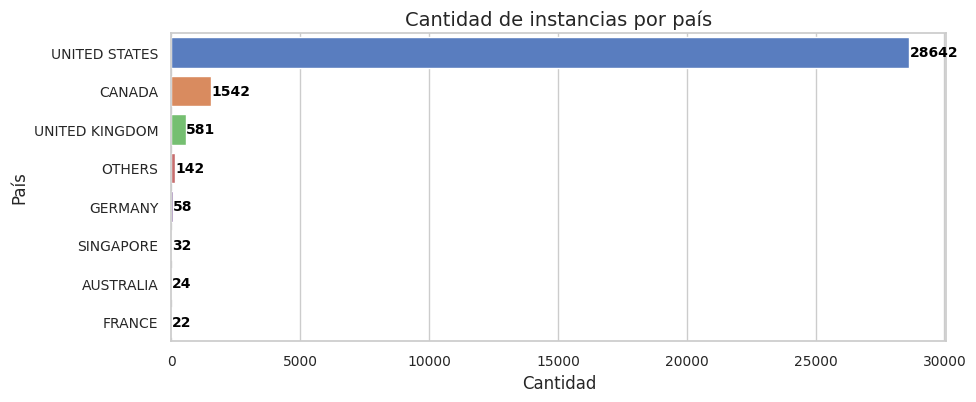

In [31]:
# Contar las instancias únicas de Country
country_counts = salaries_country['Country'].value_counts()

# Ordenar en orden descendente
country_counts = country_counts.sort_values(ascending=False)

# Establecer el estilo de Seaborn
sns.set(style="whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(10, 4))
ax = sns.barplot(x=country_counts.values, y=country_counts.index, palette="muted")

# Agregar el número de cuentas en cada barra
for i, count in enumerate(country_counts):
    ax.text(count, i, str(count), ha='left', va='center', color='black', weight='bold', fontsize=10)

# Configurar los títulos y etiquetas de los ejes
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('País', fontsize=12)
plt.title('Cantidad de instancias por país', fontsize=14)

# Cambiar el tamaño de las marcas de los ejes X e Y
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

####Empresa [Company.Name]

In [32]:
# Crear una copia del dataset anterior
salaries_company = salaries_country.copy()

In [33]:
# Genero agrupaciones o cambios de nombre para facilitar el manejo posterior de la API
groupings = {
    'META HEADQUARTERS': ['META'],
    'GOOGLEPLEX': ['GOOGLE'],
    'SALESFORCE TOWER': ['SALESFORCE'],
    'ERNST & YOUNG': ['Ernst & Young','EY'],
    "L'OREAL": ['LOREAL','LÂ€™OREAL',"L'OREAL",'LÂ€™ORÃ©AL'],
    "MCDONALD'S": ['MCDONALDS','MCDONALDÂ€™S'],
    'W/O COMPANY': ['ANONYMOUS','SELF-EMPLOYED','PRIVATE PRACTICE','START UP','.','SMALL BUSINESS','TECH COMPANY','LAW FIRM','CONFIDENTIAL',
                    'NONPROFIT','STARTUP','PUBLIC SCHOOL','HOSPITAL','PRIVATE','BANK','X','SCHOOL','REDACTED','UNIVERSITY','GOVERNMENT','AGENCY'] #Agrupo en W/O COMPANY los Company.Name que no representen a una empresa y que tengan mas de 20 repeticiones
}

# Función para agrupar categorías basadas en patrones de coincidencia
def group_company(company_name):
    for group, company_names in groupings.items():
      if company_name in company_names:
          return group
    return company_name

# Aplicar la función de agrupación a la columna 'Company.Name' y crear una nueva columna 'GroupedCompany'
salaries_company['GroupedCompany'] = salaries_company['Company.Name'].apply(group_company)


# Calcular la frecuencia de las categorías en GroupedCompany
company_counts = salaries_company['GroupedCompany'].value_counts()

# Reemplazar empresas con menos de 20 repeticiones por "OTHER"
salaries_company.loc[~salaries_company['GroupedCompany'].isin(company_counts[company_counts >= 20].index), 'GroupedCompany'] = 'OTHER'

# Calcular la frecuencia de las categorías nuevamente después del reemplazo
# company_counts_filtered = salaries_company['GroupedCompany'].value_counts()

# with pd.option_context('display.max_rows', None):
#     print(company_counts_filtered)


print("Cantidad de Empresas Agrupadas es:", len(salaries_company['GroupedCompany'].unique()))

Cantidad de Empresas Agrupadas es: 118


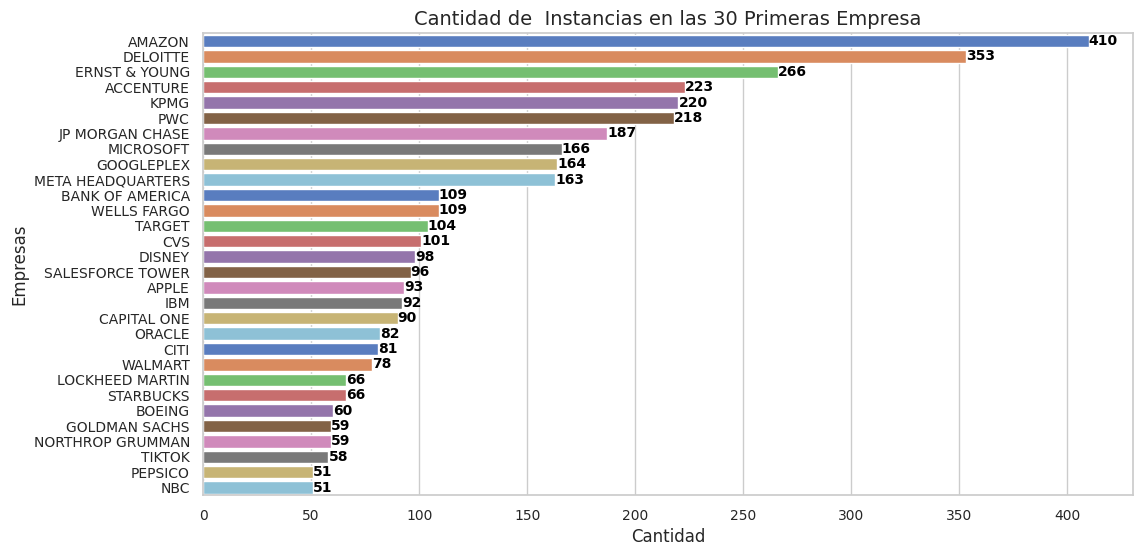

In [34]:
# Filtrar los datos 'W/O COMPANY' y 'OTHERS' de company_counts
filtered_counts = company_counts.drop(['W/O COMPANY', 'OTHERS'], errors='ignore')

# Obtener los primeros 20 valores
top_20_counts = filtered_counts.nlargest(30)

# Establecer el estilo de Seaborn
sns.set(style="whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_20_counts.values, y=top_20_counts.index, palette="muted")

# Agregar el número de cuentas en cada barra
for i, count in enumerate(top_20_counts):
    ax.text(count, i, str(count), ha='left', va='center', color='black', weight='bold', fontsize=10)

# Configurar los títulos y etiquetas de los ejes
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Empresas', fontsize=12)
plt.title('Cantidad de  Instancias en las 30 Primeras Empresa', fontsize=14)

# Cambiar el tamaño de las marcas de los ejes X e Y
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

####Conclusión de Reducción

In [35]:
# Crear una copia del dataset anterior
salaries_reduced = salaries_company.copy()

In [36]:
# Contar la cantidad de instancias únicas de las caracteristicas considerads como variables nominales

print("Cantidad de Rango de Edades Antes:", len(salaries['Age.Range'].unique()))
print("Cantidad de Rango de Edades Ahora:", len(salaries_reduced['Age.Range'].unique()))
print("----------------------------------------")
print("Cantidad de Años de Experiencia Antes:", len(salaries['Years.of.Experience'].unique()))
print("Cantidad de Años de Experiencia Ahora:", len(salaries_reduced['Years.of.Experience'].unique()))
print("----------------------------------------")
print("Cantidad de Industrias Antes:", len(salaries['Industry'].unique()))
print("Cantidad de Industrias Ahora:", len(salaries_reduced['GroupedIndustry'].unique()))
print("----------------------------------------")
print("Cantidad de Puestos de trabajo Antes:", len(salaries['Job.Title'].unique()))
print("Cantidad de Puestos de trabajo Ahora:", len(salaries_reduced['GroupedJobTitle'].unique()))
print("----------------------------------------")
print("Cantidad de Empresas Antes:", len(salaries['Company.Name'].unique()))
print("Cantidad de Empresas Ahora:", len(salaries_reduced['GroupedCompany'].unique()))
print("----------------------------------------")
print("Cantidad de Paises Antes:", len(salaries['Country'].unique()))
print("Cantidad de Paises Ahora:", len(salaries_reduced['Country'].unique()))
print("----------------------------------------")
print("Cantidad de Generos Antes:", len(salaries['Gender'].unique()))
print("Cantidad de Generos Ahora:", len(salaries_reduced['Gender'].unique()))

Cantidad de Rango de Edades Antes: 12
Cantidad de Rango de Edades Ahora: 11
----------------------------------------
Cantidad de Años de Experiencia Antes: 20
Cantidad de Años de Experiencia Ahora: 19
----------------------------------------
Cantidad de Industrias Antes: 5788
Cantidad de Industrias Ahora: 28
----------------------------------------
Cantidad de Puestos de trabajo Antes: 12918
Cantidad de Puestos de trabajo Ahora: 43
----------------------------------------
Cantidad de Empresas Antes: 15096
Cantidad de Empresas Ahora: 118
----------------------------------------
Cantidad de Paises Antes: 56
Cantidad de Paises Ahora: 8
----------------------------------------
Cantidad de Generos Antes: 3
Cantidad de Generos Ahora: 3


##Feature Engineering

###One-Hot Encoding

Se aplicará One-Hot Encoding a las siguientes características:

* Country
* Age.Range
* GroupedIndustry
* GroupedJobTitle
* Gender

Las cuales fueron elegidas debido a su naturaleza nominal y la cantidad moderada de instancias únicas en cada una de ellas. Esta técnica convierte las variables categóricas en columnas separadas con valores binarios.

In [37]:
nominal_variables = ['Country', 'Age.Range', 'GroupedIndustry', 'GroupedJobTitle', 'Gender']

# Aplicar One-Hot Encoding
salaries_one_hot = pd.get_dummies(salaries_reduced, columns=nominal_variables)

# Verificar los resultados
salaries_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31043 entries, 0 to 32569
Columns: 101 entries, Years.of.Experience to Gender_Male
dtypes: float64(2), object(6), uint8(93)
memory usage: 4.9+ MB


###Ordinal Encoding

Se aplicará Ordinal Encoding a la siguiente caracteristica:

* Education  

Se eligió este método porque la variable Education tiene un orden implícito, como por ejemplo "High School" < "Bachelor's Degree" < "Master's Degree", y el Ordinal Encoding captura esta jerarquía de manera adecuada.

In [38]:
# Analiso cuales son las instancias unicas dentro de Education
salaries_one_hot['Education'].unique()

array(['None', "Master's Degree", 'High School/GED', 'Some College',
       "Bachelor's Degree", 'Doctorate Degree', 'Trade/Vocational',
       "Associate's Degree"], dtype=object)

In [39]:
from sklearn.preprocessing import OrdinalEncoder

# Crear una copia del dataset anterior
salaries_encoded = salaries_one_hot.copy()

# Definir el orden de los tipos de estudios
education_order = ['None', 'High School/GED', 'Trade/Vocational', 'Some College', "Associate's Degree", "Bachelor's Degree", "Master's Degree", 'Doctorate Degree']

# Crear el objeto OrdinalEncoder con el orden específico
ordinal_encoder = OrdinalEncoder(categories=[education_order])

# Aplicar el encoding ordinal a la columna 'Education'
salaries_encoded['Education'] = ordinal_encoder.fit_transform(salaries_encoded[['Education']])

# Verificar los resultados
salaries_encoded

,Years.of.Experience,Industry,Job.Title,Company.Name,Education,Monthly.SalaryUSD,Salary.Period,GroupedCompany,Country_AUSTRALIA,Country_CANADA,...,GroupedJobTitle_Store Manager,GroupedJobTitle_Supervisor,GroupedJobTitle_Teacher,GroupedJobTitle_Testing & Quality Assurance,GroupedJobTitle_Therapist,GroupedJobTitle_Underwriter,GroupedJobTitle_V Level,Gender_Female,Gender_LGBTQ+,Gender_Male
0,3.0,GAMING,STREAMER,TWITCH,0.0,40833.333333,Annual,OTHER,0,0,...,0,0,0,0,0,0,0,0,0,1
1,5.0,HEALTHCARE,AESTHETIC NURSE PRACTITIONER/BUSINESS OWNER,AESTHETIC CLINIC,6.0,31691.088207,Annual,OTHER,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1.0,ONLINE ARCADE,OWNER,RUST CLASH,1.0,40000.000000,Annual,OTHER,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2.0,CRYPTO,HEAD OF MARKETING,REDACTED,3.0,40000.000000,Annual,W/O COMPANY,0,0,...,0,0,0,0,0,0,0,0,0,1
4,13.0,WINDOW COVERINGS,OWNER,CAROLINA BLIND CRAFTERS,5.0,40000.000000,Annual,OTHER,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31756,5.0,EDUCATION,PARAEDUCATOR,ELEMENTARY SCHOOL,4.0,0.750000,Annual,OTHER,0,0,...,0,0,0,0,0,0,0,1,0,0
31757,5.0,ECOMMERCE,DESIGN MANAGER,MIS,5.0,0.092258,Monthly,OTHER,0,0,...,0,0,0,0,0,0,0,0,0,1
31758,5.0,HOTEL/RESTAURANT,MANAGER/CHEF,CASA BAROLO,5.0,1.363698,Monthly,OTHER,0,0,...,0,0,0,0,0,0,0,1,0,0
32568,4.0,MATERIAL HANDLING,SOLUTIONS CONSULTANT,DEMATIC,5.0,9166.666667,Annual,OTHER,0,0,...,0,0,0,0,0,0,0,0,0,1


In [40]:
print(salaries_encoded.columns)


Index(['Years.of.Experience', 'Industry', 'Job.Title', 'Company.Name',
       'Education', 'Monthly.SalaryUSD', 'Salary.Period', 'GroupedCompany',
       'Country_AUSTRALIA', 'Country_CANADA',
       ...
       'GroupedJobTitle_Store Manager', 'GroupedJobTitle_Supervisor',
       'GroupedJobTitle_Teacher',
       'GroupedJobTitle_Testing & Quality Assurance',
       'GroupedJobTitle_Therapist', 'GroupedJobTitle_Underwriter',
       'GroupedJobTitle_V Level', 'Gender_Female', 'Gender_LGBTQ+',
       'Gender_Male'],
      dtype='object', length=101)


##Machine Learning

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [42]:
X = salaries_encoded.drop(columns=['Industry', 'Job.Title', 'Company.Name', 'Monthly.SalaryUSD', 'Salary.Period',	'GroupedCompany'])
y = salaries_encoded['Monthly.SalaryUSD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

###Análisis de Correlación

In [43]:
# Calcular la matriz de correlación
correlation_matrix = salaries_encoded.corr()

# Ordenar las correlaciones con la variable objetivo
salary_correlation = correlation_matrix["Monthly.SalaryUSD"].sort_values(ascending=False)

# Mostrar las correlaciones
print(salary_correlation)

<ipython-input-43-9003c03c7ee7>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = salaries_encoded.corr()


Monthly.SalaryUSD                       1.000000
Years.of.Experience                     0.311018
Education                               0.211898
Gender_Male                             0.174548
Age.Range_34-37                         0.154484
                                          ...   
GroupedIndustry_Education & Research   -0.109859
GroupedJobTitle_Assistant              -0.119742
Age.Range_18-21                        -0.125948
Gender_Female                          -0.170985
Age.Range_22-25                        -0.219821
Name: Monthly.SalaryUSD, Length: 96, dtype: float64


In [44]:
# Calcular la correlación entre las características y el objetivo
correlation = pd.concat([X, y], axis=1).corr()['Monthly.SalaryUSD'].abs()

# Ordenar las características por su correlación con el objetivo
selected_features = correlation.drop('Monthly.SalaryUSD').nlargest(15)

# Crear un DataFrame con las características y su correlación
feature_correlation = pd.DataFrame({'Feature': selected_features.index, 'Correlation': selected_features.values})

# Restablecer los índices del DataFrame
feature_correlation = feature_correlation.reset_index(drop=True)

# Imprimir el DataFrame
print(feature_correlation)

                              Feature  Correlation
0                 Years.of.Experience     0.311018
1                     Age.Range_22-25     0.219821
2                           Education     0.211898
3                         Gender_Male     0.174548
4                       Gender_Female     0.170985
5                     Age.Range_34-37     0.154484
6                     Age.Range_30-33     0.146993
7          GroupedIndustry_Technology     0.146801
8   GroupedJobTitle_Software Engineer     0.133630
9            GroupedJobTitle_Director     0.129413
10                    Age.Range_18-21     0.125948
11                    Age.Range_38-41     0.119756
12          GroupedJobTitle_Assistant     0.119742
13              Country_UNITED STATES     0.118069
14            GroupedJobTitle_V Level     0.113770


<ipython-input-45-73e3251867a2>:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_target = salaries_encoded.drop('Monthly.SalaryUSD', axis=1).corrwith(salaries['Monthly.SalaryUSD'])


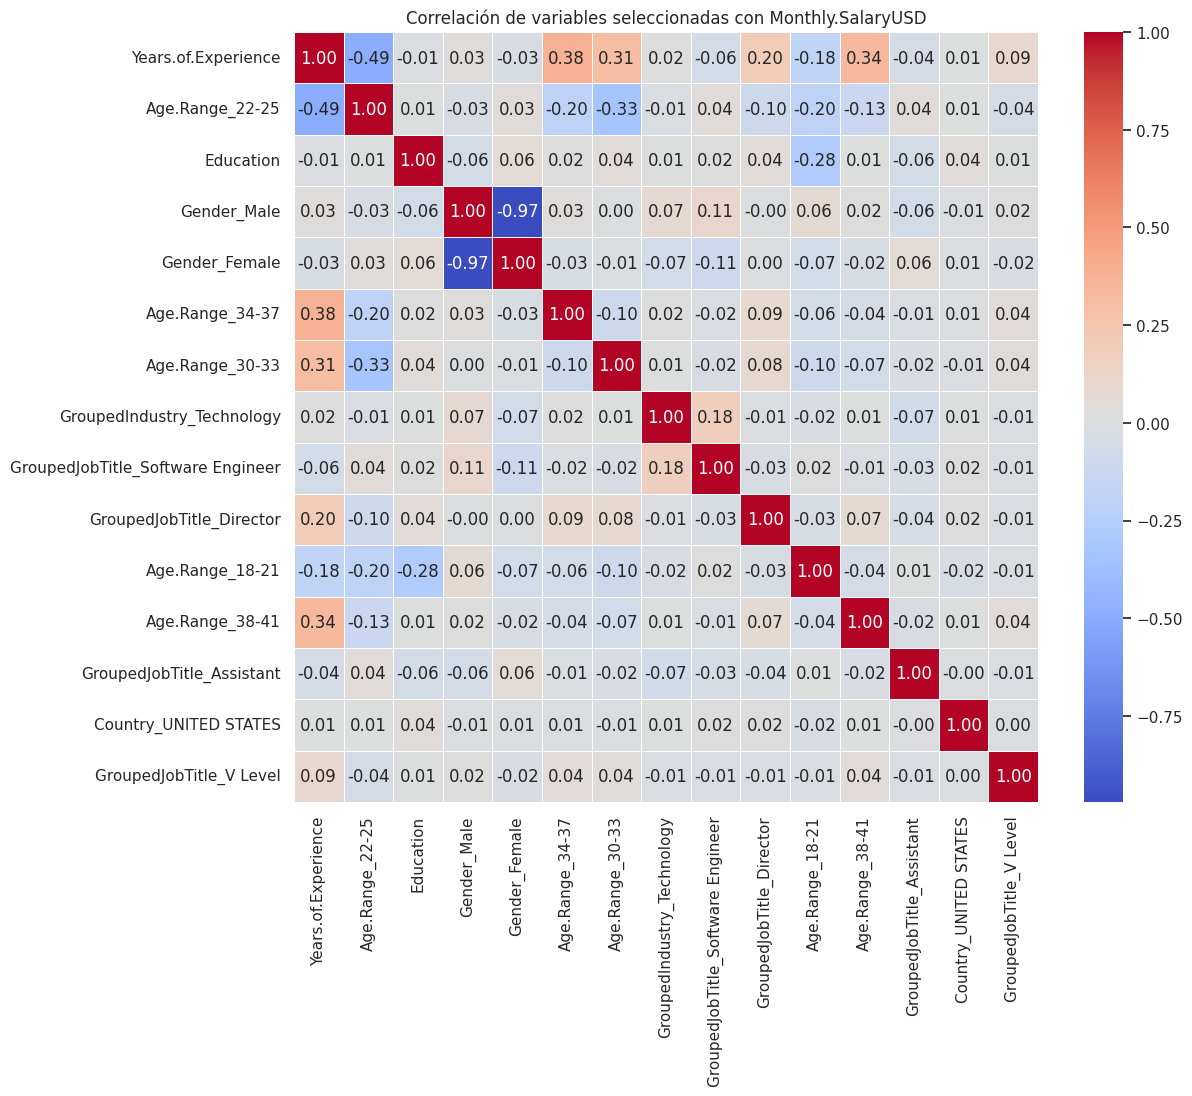

In [45]:
# Calcular la correlación con la variable objetivo
correlation_with_target = salaries_encoded.drop('Monthly.SalaryUSD', axis=1).corrwith(salaries['Monthly.SalaryUSD'])

# Seleccionar las variables con mayor correlación
top_features = correlation_with_target.abs().nlargest(15).index

# Crear el mapa de calor para las variables seleccionadas
selected_variables = salaries_encoded[top_features]
correlation_matrix = selected_variables.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlación de variables seleccionadas con Monthly.SalaryUSD')
plt.show()


Según los resultados obtenidos en el análisis de correlación, las características más relevantes para predecir el salario mensual (Monthly.SalaryUSD) son:

1. **Years.of.Experience:** Una vez más, la experiencia laboral muestra una correlación positiva significativa de 0.311018 con el salario mensual. Esto reafirma la idea de que a medida que aumenta la experiencia, es probable que el salario también se incremente.

2. **Age Ranges:** Los diferentes grupos de edad continúan demostrando correlaciones positivas con los salarios mensuales. El rango de edad entre 22 y 25 años (0.219821), junto con Age.Range_34-37 (0.154484) y Age.Range_30-33 (0.146993), sugieren que los profesionales en estas etapas de la vida laboral pueden beneficiarse de salarios más altos.

3. **Education:** La educación sigue demostrando una influencia positiva (0.211898) en los salarios mensuales. Un mayor nivel educativo podría seguir estando relacionado con remuneraciones más sustanciales.

4. **Gender:** En términos de género, tanto Gender_Male (0.174548) como Gender_Female (0.170985) muestran correlaciones positivas similares con los salarios mensuales. Esto sugiere que la equidad de género podría estar mejorando en cuanto a salarios en esta muestra.

5. **Grouped Industry and Job Titles:** Se observa una correlación positiva con GroupedIndustry_Technology (0.146801) y diversas categorías de títulos laborales agrupados, como GroupedJobTitle_Software Engineer (0.133630) y GroupedJobTitle_Director (0.129413). Esto respalda la noción de que pertenecer a ciertas industrias y ocupaciones puede contribuir a salarios más elevados.

Basándonos en estos hallazgos, se puede justificar la elección de los siguientes modelos de Machine Learning para predecir el salario mensual:
1. Random Forest
2. Gradient Boosting
3. XGBoost

La elección de estos tres modelos se basa en su capacidad para tratar las características relevantes identificadas y su capacidad para generar predicciones precisas en problemas de regresión.

###Rescaleo de Datos

In [46]:
# Crear una instancia del escalador
scaler = StandardScaler()

# Ajustar el escalador en los datos de entrenamiento y aplicarlo a los datos de prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
from sklearn.decomposition import PCA

# Especificar el número de componentes principales deseado
num_components = 10  # Por ejemplo, puedes ajustar este valor

# Crear una instancia de PCA
pca = PCA(n_components=num_components)

# Ajustar PCA a tus datos escalados de entrenamiento y transformarlos
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

### Random Forest




Los modelos de Random Forest son conocidos por su capacidad para manejar características numéricas y categóricas, como las que tenemos en nuestro conjunto de datos después de aplicar One Hot Encoding y Ordinal Encoding. También son robustos frente a datos ruidosos y tienen un buen rendimiento en problemas de regresión.


In [48]:
# Crear y Entrenar el modelo de Random Forest
model_random = RandomForestRegressor()
model_random.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model_random.predict(X_test_scaled)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calcular la raíz del error cuadrático medio (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calcular el coeficiente de determinación (R2)
r2 = r2_score(y_test, y_pred)

print("Error cuadrático medio (MSE): ", mse)
print("Raíz del error cuadrático medio (RMSE): ", rmse)
print("Error absoluto medio (MAE): ", mae)
print("Coeficiente de determinación (R2): ", r2)

Error cuadrático medio (MSE):  9364440.58933543
Raíz del error cuadrático medio (RMSE):  3060.1373481161645
Error absoluto medio (MAE):  1957.8018923700397
Coeficiente de determinación (R2):  0.27827981736070595


###Gradient Boosting


Los modelos de Gradient Boosting, como el Gradient Boosting Regressor, son poderosos en problemas de regresión y pueden manejar características numéricas y categóricas. Estos modelos tienen una alta capacidad de generalización y pueden capturar relaciones no lineales entre las características y el objetivo.

In [49]:
# Crear y entrenar el modelo de Gradient Boosting
model_gradient = GradientBoostingRegressor()
model_gradient.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model_gradient.predict(X_test_scaled)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calcular la raíz del error cuadrático medio (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calcular el coeficiente de determinación (R2)
r2 = r2_score(y_test, y_pred)

print("Error cuadrático medio (MSE): ", mse)
print("Raíz del error cuadrático medio (RMSE): ", rmse)
print("Error absoluto medio (MAE): ", mae)
print("Coeficiente de determinación (R2): ", r2)


Error cuadrático medio (MSE):  8415951.705999892
Raíz del error cuadrático medio (RMSE):  2901.02597471996
Error absoluto medio (MAE):  1886.6193404246294
Coeficiente de determinación (R2):  0.35138013377382393


###XGBoost

XGBoost es una implementación mejorada del Gradient Boosting y ha demostrado ser eficiente y efectiva en una amplia gama de problemas de regresión. XGBoost tiene una capacidad inherente para manejar características mixtas y puede proporcionar predicciones precisas.

In [50]:
# Crear y Entrenar el modelo de XGBoost
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model_xgb.predict(X_test_scaled)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calcular la raíz del error cuadrático medio (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calcular el coeficiente de determinación (R2)
r2 = r2_score(y_test, y_pred)

print("Error cuadrático medio (MSE): ", mse)
print("Raíz del error cuadrático medio (RMSE): ", rmse)
print("Error absoluto medio (MAE): ", mae)
print("Coeficiente de determinación (R2): ", r2)

Error cuadrático medio (MSE):  8290828.847676742
Raíz del error cuadrático medio (RMSE):  2879.379941528513
Error absoluto medio (MAE):  1834.485959218734
Coeficiente de determinación (R2):  0.3610233891610358


Para poder mejorar los valores obtenidos en el modelo XGBoost anterior, se utilizó una búsqueda de cuadrícula para encontrar los mejores hiperparámetros.

Se ajustaron los hiperparámetros de learning_rate, max_depth, min_child_weight y n_estimators en un rango específico.


```
param_grid = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5, 7, 10],
    'min_child_weight': [1, 2]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2)
grid_result = grid.fit(X_train_scaled, y_train)
```


Luego de aproximadamente 3 horas, se encontraron los siguientes hiperparámetros óptimos:

* Learning Rate: 0.1
* Max Depth: 4
* Min Child Weight: 1
* Number of Estimators: 300

Los cuales se utilizarán a continuación:

In [51]:
# Crear un modelo de XGBoost con los hiperparamentros obtenidos
model_xgb = XGBRegressor(learning_rate=0.1,
                     max_depth=4,
                     min_child_weight=1,
                     n_estimators=300,
                     objective='reg:squarederror', random_state=42)

# Entrenar el modelo
model_xgb.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model_xgb.predict(X_test_scaled)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calcular la raíz del error cuadrático medio (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calcular el coeficiente de determinación (R2)
r2 = r2_score(y_test, y_pred)

print("Error cuadrático medio (MSE): ", mse)
print("Raíz del error cuadrático medio (RMSE): ", rmse)
print("Error absoluto medio (MAE): ", mae)
print("Coeficiente de determinación (R2): ", r2)

Error cuadrático medio (MSE):  8011417.579499139
Raíz del error cuadrático medio (RMSE):  2830.444767081516
Error absoluto medio (MAE):  1819.7892671037594
Coeficiente de determinación (R2):  0.3825576975457


###Selección de un Modelo

Después de evaluar los modelos de Random Forest, Gradient Boosting y XGBoost para predecir el salario mensual (Monthly.SalaryUSD), se seleccionó el modelo XGBoost debido a su mejor rendimiento en términos de métricas de evaluación como MSE, RMSE, MAE y R2. Si bien se reconoce que los resultados obtenidos no son los ideales, se es consciente de que se requerirán iteraciones y mejoras adicionales en el modelo en etapas posteriores. Esto incluirá la optimización de hiperparámetros, la consideración de nuevas características relevantes y otras técnicas para mejorar la precisión de las predicciones.

Las razones de porqué se eligió XGBoost son:

1. Error cuadrático medio (MSE) y Raíz del error cuadrático medio (RMSE): El modelo XGBoost tiene un MSE y RMSE más bajos en comparación con los otros dos modelos. Esto significa que el modelo XGBoost tiene una mejor capacidad para reducir el error en las predicciones del salario mensual. Un menor MSE y RMSE indican una mejor precisión en las predicciones.

2. Error absoluto medio (MAE): El modelo XGBoost también tiene un MAE más bajo en comparación con los otros dos modelos. Esto indica que el modelo XGBoost tiene una menor diferencia promedio entre las predicciones y los valores reales del salario mensual. Un MAE más bajo sugiere una mejor capacidad para hacer predicciones más cercanas a los valores reales.

3. Coeficiente de determinación (R2): El modelo XGBoost tiene el coeficiente de determinación (R2) más alto entre los tres modelos. El R2 mide la proporción de la varianza en el objetivo que se puede explicar por las características del modelo. Un valor de R2 más alto indica una mejor capacidad del modelo para capturar la variabilidad en los datos y hacer predicciones más precisas.


###Análisis Gráfico del Modelo Elegido

In [52]:
# Obtener la cantidad de árboles generados en XGBoost
num_trees = model_xgb.best_iteration
# Otra opción: num_trees = model.best_iteration_

print("Número de árboles generados:", num_trees)

Número de árboles generados: 299


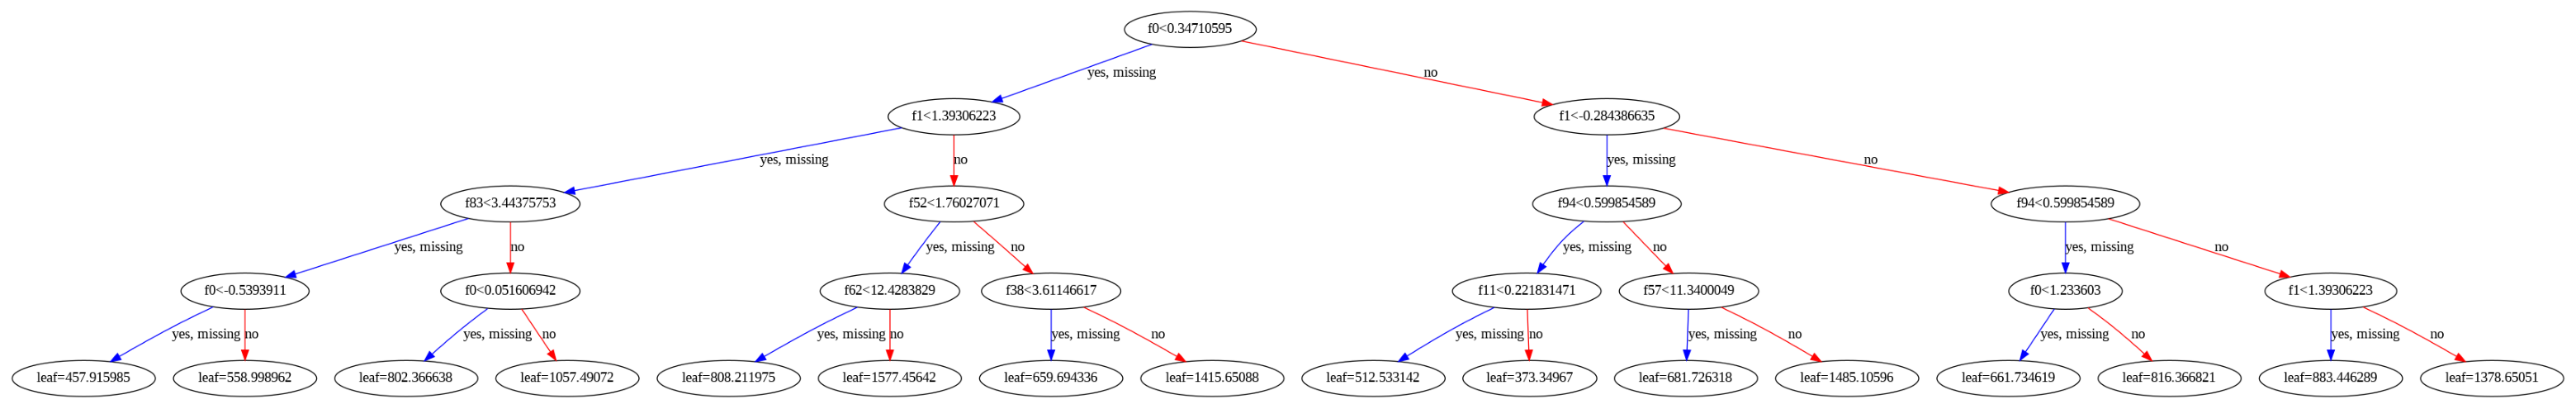

In [53]:
# Obtener el primer árbol del modelo
tree = model_xgb.get_booster().get_dump()[0]

# Graficar el ultimo árbol de decisión
fig, ax = plt.subplots(figsize=(40,35))
xgb.plot_tree(model_xgb, num_trees=1, ax=ax)
plt.show()


In [54]:
# Obtener las predicciones en el conjunto de prueba
y_pred = model_xgb.predict(X_test_scaled)

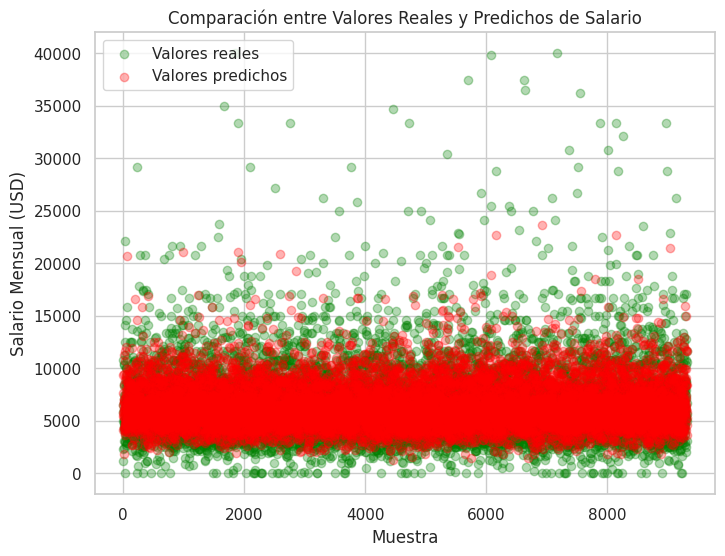

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))

# Gráfico de dispersión para valores reales
ax.scatter(range(len(y_test)), y_test, c='green', label='Valores reales', alpha=0.3)

# Gráfico de dispersión para valores predichos
ax.scatter(range(len(y_pred)), y_pred, c='red', label='Valores predichos', alpha=0.3)

# Etiquetas de ejes y título
ax.set_xlabel('Muestra')
ax.set_ylabel('Salario Mensual (USD)')
ax.set_title('Comparación entre Valores Reales y Predichos de Salario')
ax.legend()

plt.show()

Text(0.5, 1.0, 'Curva de Aprendizaje')

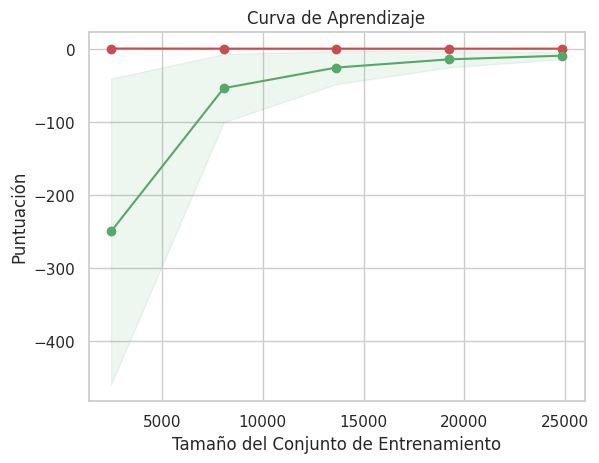

In [56]:
# Obtener la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(model_xgb, X, y, cv=5)

# Calcular las medias y desviaciones estándar de las puntuaciones de entrenamiento y prueba
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear un gráfico de curva de aprendizaje
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Puntuación de Entrenamiento')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Puntuación de Validación Cruzada')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Puntuación')
plt.title('Curva de Aprendizaje')

In [57]:
# Obtener las predicciones de los modelos individuales
predictions_rf = model_random.predict(X_test_scaled)
predictions_gb = model_gradient.predict(X_test_scaled)
predictions_xgb = model_xgb.predict(X_test_scaled)

###Ensamblaje por Votación Ponderada

In [58]:
# Calcular las predicciones ponderadas
predictions_combined = (0.1 * predictions_rf) + (0.1 * predictions_gb) + (0.8 * predictions_xgb)

# Evaluar el rendimiento del modelo combinado
mse_combined = mean_squared_error(y_test, predictions_combined)
rmse_combined = np.sqrt(mse_combined)
mae_combined = mean_absolute_error(y_test, predictions_combined)
r2_combined = r2_score(y_test, predictions_combined)

# Imprimir las métricas de evaluación del modelo combinado
print("Error cuadrático medio (MSE) del modelo combinado:", mse_combined)
print("Raíz del error cuadrático medio (RMSE) del modelo combinado:", rmse_combined)
print("Error absoluto medio (MAE) del modelo combinado:", mae_combined)
print("Coeficiente de determinación (R2) del modelo combinado:", r2_combined)

Error cuadrático medio (MSE) del modelo combinado: 7974656.446212398
Raíz del error cuadrático medio (RMSE) del modelo combinado: 2823.943421213038
Error absoluto medio (MAE) del modelo combinado: 1815.147965496003
Coeficiente de determinación (R2) del modelo combinado: 0.3853908888694775


###Redes Neuronales

En el proceso de mejora de modelos, se realizó una prueba utilizando redes neuronales para abordar el problema. Sin embargo, a pesar de los esfuerzos, los resultados obtenidos no superaron los valores logrados con el modelo XGBoost.

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

# Crear una red neuronal con más capas y Dropout
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.5))  # Capa Dropout para prevenir sobreajuste
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Capa Dropout para prevenir sobreajuste
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Capa de salida para regresión

# Utilizar el optimizador RMSprop con una tasa de aprendizaje ajustada
optimizer = RMSprop(learning_rate=0.001)

# Compilar el modelo con el nuevo optimizador
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entrenar el modelo con un número mayor de épocas
model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, verbose=1)

# Evaluar el modelo en los datos de prueba
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error on Test Data:", mse)
print("R2 Score on Test Data:", r2)

Epoch 1/200
680/680 [==============================] - 3s 3ms/step - loss: 24471054.0000
Epoch 2/200
680/680 [==============================] - 2s 3ms/step - loss: 11023479.0000
Epoch 3/200
680/680 [==============================] - 1s 2ms/step - loss: 10641147.0000
Epoch 4/200
680/680 [==============================] - 1s 2ms/step - loss: 10368395.0000
Epoch 5/200
680/680 [==============================] - 1s 2ms/step - loss: 10221785.0000
Epoch 6/200
680/680 [==============================] - 1s 2ms/step - loss: 10094740.0000
Epoch 7/200
680/680 [==============================] - 1s 2ms/step - loss: 9993500.0000
Epoch 8/200
680/680 [==============================] - 1s 2ms/step - loss: 9905121.0000
Epoch 9/200
680/680 [==============================] - 1s 2ms/step - loss: 9799383.0000
Epoch 10/200
680/680 [==============================] - 3s 4ms/step - loss: 9712865.0000
Epoch 11/200
680/680 [==============================] - 2s 3ms/step - loss: 9673566.0000
Epoch 12/200
680/680 [==

## Segunda ronda de entrenamiento


Para la segunda ronda de entrenamiento, en el proceso de Feature Engineering, se eliminará la columna **GroupedIndustry**.

Luego, se generarán DataFrames independientes para cada **GroupedIndustry**. Esto nos permitirá entrenar modelos específicos para cada industria, lo que puede mejorar la capacidad de predicción y ajuste de nuestros modelos a las características únicas de cada sector industrial.

Al hacerlo, se espera optimizar aún más nuestro proceso de modelado y obtener mejores resultados en la predicción de salarios para diferentes industrias.

### Feature Engineering


In [60]:
nominal_variables = ['Country', 'Age.Range', 'GroupedJobTitle', 'Gender']

# Aplicar One-Hot Encoding
salaries_one_hot_2 = pd.get_dummies(salaries_reduced, columns=nominal_variables)

# Verificar los resultados
salaries_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31043 entries, 0 to 32569
Columns: 101 entries, Years.of.Experience to Gender_Male
dtypes: float64(2), object(6), uint8(93)
memory usage: 5.9+ MB


In [61]:
from sklearn.preprocessing import OrdinalEncoder

# Crear una copia del dataset anterior
salaries_encoded_2 = salaries_one_hot_2.copy()

# Definir el orden de los tipos de estudios
education_order = ['None', 'High School/GED', 'Trade/Vocational', 'Some College', "Associate's Degree", "Bachelor's Degree", "Master's Degree", 'Doctorate Degree']

# Crear el objeto OrdinalEncoder con el orden específico
ordinal_encoder = OrdinalEncoder(categories=[education_order])

# Aplicar el encoding ordinal a la columna 'Education'
salaries_encoded_2['Education'] = ordinal_encoder.fit_transform(salaries_encoded_2[['Education']])

# Verificar los resultados
salaries_encoded_2

,Years.of.Experience,Industry,Job.Title,Company.Name,Education,Monthly.SalaryUSD,Salary.Period,GroupedIndustry,GroupedCompany,Country_AUSTRALIA,...,GroupedJobTitle_Store Manager,GroupedJobTitle_Supervisor,GroupedJobTitle_Teacher,GroupedJobTitle_Testing & Quality Assurance,GroupedJobTitle_Therapist,GroupedJobTitle_Underwriter,GroupedJobTitle_V Level,Gender_Female,Gender_LGBTQ+,Gender_Male
0,3.0,GAMING,STREAMER,TWITCH,0.0,40833.333333,Annual,Gaming,OTHER,0,...,0,0,0,0,0,0,0,0,0,1
1,5.0,HEALTHCARE,AESTHETIC NURSE PRACTITIONER/BUSINESS OWNER,AESTHETIC CLINIC,6.0,31691.088207,Annual,Healthcare,OTHER,0,...,0,0,0,0,0,0,0,0,0,1
2,1.0,ONLINE ARCADE,OWNER,RUST CLASH,1.0,40000.000000,Annual,Gaming,OTHER,0,...,0,0,0,0,0,0,0,0,0,1
3,2.0,CRYPTO,HEAD OF MARKETING,REDACTED,3.0,40000.000000,Annual,Others,W/O COMPANY,0,...,0,0,0,0,0,0,0,0,0,1
4,13.0,WINDOW COVERINGS,OWNER,CAROLINA BLIND CRAFTERS,5.0,40000.000000,Annual,Others,OTHER,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31756,5.0,EDUCATION,PARAEDUCATOR,ELEMENTARY SCHOOL,4.0,0.750000,Annual,Education & Research,OTHER,0,...,0,0,0,0,0,0,0,1,0,0
31757,5.0,ECOMMERCE,DESIGN MANAGER,MIS,5.0,0.092258,Monthly,Retail,OTHER,0,...,0,0,0,0,0,0,0,0,0,1
31758,5.0,HOTEL/RESTAURANT,MANAGER/CHEF,CASA BAROLO,5.0,1.363698,Monthly,Food & Beverage,OTHER,0,...,0,0,0,0,0,0,0,1,0,0
32568,4.0,MATERIAL HANDLING,SOLUTIONS CONSULTANT,DEMATIC,5.0,9166.666667,Annual,Others,OTHER,0,...,0,0,0,0,0,0,0,0,0,1


### DataFrames por Industria

In [62]:
# Filtrar las industrias con menos de 1000 repeticiones
industry_counts = salaries_encoded_2['GroupedIndustry'].value_counts()
small_industries = industry_counts[industry_counts < 1000].index
salaries_encoded_2.loc[salaries_encoded_2['GroupedIndustry'].isin(small_industries), 'GroupedIndustry'] = 'Others'

# Calcular la frecuencia de las categorías en GroupedIndustry
industry_counts = salaries_encoded_2['GroupedIndustry'].value_counts()
with pd.option_context('display.max_rows', None):
    print(industry_counts)

Others                  9672
Technology              7519
Healthcare              4068
Finance                 4061
Education & Research    1615
Retail                  1530
Marketing               1323
Consulting              1255
Name: GroupedIndustry, dtype: int64


In [63]:
# Iterar sobre las industrias únicas y separar en nuevos DataFrames
unique_industries = salaries_encoded_2['GroupedIndustry'].unique()
dataframes_by_industry = {}

for industry in unique_industries:
    cleaned_industry_name = industry.replace(" ", "_").replace("&", "").replace("/", "").replace("-", "")
    dataframe_name = f"salaries_encoded_{cleaned_industry_name}"
    dataframes_by_industry[dataframe_name] = salaries_encoded_2[salaries_encoded_2['GroupedIndustry'] == industry]

    # Mostrar información del DataFrame
    print(dataframe_name)
    print("-" * 40)

salaries_encoded_Others
----------------------------------------
salaries_encoded_Healthcare
----------------------------------------
salaries_encoded_Finance
----------------------------------------
salaries_encoded_Marketing
----------------------------------------
salaries_encoded_Technology
----------------------------------------
salaries_encoded_Education__Research
----------------------------------------
salaries_encoded_Consulting
----------------------------------------
salaries_encoded_Retail
----------------------------------------


In [64]:
# Obtener las industrias únicas en 'GroupedIndustry'
unique_industries = salaries_encoded_2['GroupedIndustry'].unique()

# Iterar sobre las industrias únicas y crear DataFrames independientes
for industry in unique_industries:
    # Filtrar el DataFrame original para obtener solo la industria actual
    industry_df = salaries_encoded_2[salaries_encoded_2['GroupedIndustry'] == industry].copy()  # Copiar para mantenerlo independiente

    # Limpia el nombre de la industria para usarlo como nombre de variable
    cleaned_industry_name = industry.replace(" ", "_").replace("&", "").replace("/", "").replace("-", "")

    # Crea una variable global con el nombre del DataFrame
    globals()[f"salaries_encoded_{cleaned_industry_name}"] = industry_df

    # Mostrar información del DataFrame
    print(f"Nombre del DataFrame: salaries_encoded_{cleaned_industry_name}")
    print(f"Número de filas en el DataFrame: {len(industry_df)}")
    print("-" * 40)

Nombre del DataFrame: salaries_encoded_Others
Número de filas en el DataFrame: 9672
----------------------------------------
Nombre del DataFrame: salaries_encoded_Healthcare
Número de filas en el DataFrame: 4068
----------------------------------------
Nombre del DataFrame: salaries_encoded_Finance
Número de filas en el DataFrame: 4061
----------------------------------------
Nombre del DataFrame: salaries_encoded_Marketing
Número de filas en el DataFrame: 1323
----------------------------------------
Nombre del DataFrame: salaries_encoded_Technology
Número de filas en el DataFrame: 7519
----------------------------------------
Nombre del DataFrame: salaries_encoded_Education__Research
Número de filas en el DataFrame: 1615
----------------------------------------
Nombre del DataFrame: salaries_encoded_Consulting
Número de filas en el DataFrame: 1255
----------------------------------------
Nombre del DataFrame: salaries_encoded_Retail
Número de filas en el DataFrame: 1530
------------

### Machine Learning

In [65]:
# Entrenar modelos XGBoost para cada DataFrame
models = {}

for industry, df in dataframes_by_industry.items():
    y = df['Monthly.SalaryUSD']
    X = df.drop(columns=['Industry', 'Job.Title', 'Company.Name', 'Monthly.SalaryUSD', 'Salary.Period',	'GroupedCompany','GroupedIndustry'])

    # Escalar los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Dividir en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Crear un modelo de XGBoost con los hiperparámetros
    model_xgb = XGBRegressor(
        learning_rate=0.1,
        max_depth=4,
        min_child_weight=1,
        n_estimators=300,
        objective='reg:squarederror',
        random_state=42
    )

    # Entrenar el modelo XGBoost
    model_xgb.fit(X_train, y_train)
    models[industry] = model_xgb

    # Realizar predicciones en el conjunto de prueba
    y_pred = model_xgb.predict(X_test)

    # Calcular métricas de evaluación
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Industry: {industry}")
    print("Error cuadrático medio (MSE): ", mse)
    print("Raíz del error cuadrático medio (RMSE): ", rmse)
    print("Error absoluto medio (MAE): ", mae)
    print("Coeficiente de determinación (R2): ", r2)
    print("-" * 40)

Industry: salaries_encoded_Others
Error cuadrático medio (MSE):  11524884.409152078
Raíz del error cuadrático medio (RMSE):  3394.832014864959
Error absoluto medio (MAE):  1981.7607293985573
Coeficiente de determinación (R2):  0.2650234567598375
----------------------------------------
Industry: salaries_encoded_Healthcare
Error cuadrático medio (MSE):  10528680.732346553
Raíz del error cuadrático medio (RMSE):  3244.7928643207033
Error absoluto medio (MAE):  1979.9916624471616
Coeficiente de determinación (R2):  0.42857422531005374
----------------------------------------
Industry: salaries_encoded_Finance
Error cuadrático medio (MSE):  6251937.345305761
Raíz del error cuadrático medio (RMSE):  2500.3874390393503
Error absoluto medio (MAE):  1640.1156280254297
Coeficiente de determinación (R2):  0.3268605446100161
----------------------------------------
Industry: salaries_encoded_Marketing
Error cuadrático medio (MSE):  5853602.957746196
Raíz del error cuadrático medio (RMSE):  2419.

Se realizó la búsqueda de hiperparámetros por cada industria con GridSearchCV para optimizar el rendimiento del modelo XGBoost adaptándolo a las características específicas de cada conjunto de industria. Los hiperparámetros utilizados para el análisis fueron:

```
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [100, 200, 300, 500, 700, 1000],
}
```

Luego de aproximadamente 3 horas, se encontraron los siguientes hiperparámetros óptimos:



```
best_hyperparameters = {
    'salaries_encoded_Others': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
    'salaries_encoded_Healthcare': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
    'salaries_encoded_Finance': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 700},
    'salaries_encoded_Marketing': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300},
    'salaries_encoded_Technology': {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000},
    'salaries_encoded_Education__Research': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500},
    'salaries_encoded_Consulting': {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500},
    'salaries_encoded_Retail': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
}
```

Los cuales se utilizarán a continuación:

In [66]:
# Define los mejores hiperparámetros encontrados durante la búsqueda
best_hyperparameters = {
    'salaries_encoded_Others': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
    'salaries_encoded_Healthcare': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
    'salaries_encoded_Finance': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 700},
    'salaries_encoded_Marketing': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300},
    'salaries_encoded_Technology': {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000},
    'salaries_encoded_Education__Research': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500},
    'salaries_encoded_Consulting': {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500},
    'salaries_encoded_Retail': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
}

# Entrenar modelos XGBoost para cada DataFrame usando los mejores hiperparámetros
models = {
    'salaries_encoded_Others': None,
    'salaries_encoded_Healthcare': None,
    'salaries_encoded_Finance': None,
    'salaries_encoded_Marketing': None,
    'salaries_encoded_Technology': None,
    'salaries_encoded_Education__Research': None,
    'salaries_encoded_Consulting': None,
    'salaries_encoded_Retail': None,
}

for industry, df in dataframes_by_industry.items():
    y = df['Monthly.SalaryUSD']
    X = df.drop(columns=['Industry', 'Job.Title', 'Company.Name', 'Monthly.SalaryUSD', 'Salary.Period', 'GroupedCompany', 'GroupedIndustry'])

    # Escalar los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Dividir en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Crear un modelo de XGBoost con los mejores hiperparámetros
    best_params = best_hyperparameters[industry]
    model_xgb = XGBRegressor(
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        objective='reg:squarederror',
        random_state=42
    )

    # Entrenar el modelo XGBoost
    model_xgb.fit(X_train, y_train)

     # Asignar el modelo a la variable correspondiente
    if industry == 'salaries_encoded_Others':
        model_others = model_xgb
    elif industry == 'salaries_encoded_Healthcare':
        model_healthcare = model_xgb
    elif industry == 'salaries_encoded_Finance':
        model_finance = model_xgb
    elif industry == 'salaries_encoded_Marketing':
        model_marketing = model_xgb
    elif industry == 'salaries_encoded_Technology':
        model_technology = model_xgb
    elif industry == 'salaries_encoded_Education__Research':
        model_education_research = model_xgb
    elif industry == 'salaries_encoded_Consulting':
        model_consulting = model_xgb
    elif industry == 'salaries_encoded_Retail':
        model_retail = model_xgb

    # Realizar predicciones en el conjunto de prueba
    y_pred = model_xgb.predict(X_test)

    # Calcular métricas de evaluación
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Industry: {industry}")
    print("Mejores hiperparámetros utilizados:", best_params)
    print("Error cuadrático medio (MSE): ", mse)
    print("Raíz del error cuadrático medio (RMSE): ", rmse)
    print("Error absoluto medio (MAE): ", mae)
    print("Coeficiente de determinación (R2): ", r2)
    print("-" * 40)

Industry: salaries_encoded_Others
Mejores hiperparámetros utilizados: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Error cuadrático medio (MSE):  11086572.368519077
Raíz del error cuadrático medio (RMSE):  3329.6504874414486
Error absoluto medio (MAE):  1962.5879056304827
Coeficiente de determinación (R2):  0.2929759339429633
----------------------------------------
Industry: salaries_encoded_Healthcare
Mejores hiperparámetros utilizados: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Error cuadrático medio (MSE):  10669680.633954678
Raíz del error cuadrático medio (RMSE):  3266.4477087433493
Error absoluto medio (MAE):  1995.6742587191636
Coeficiente de determinación (R2):  0.4209217016885427
----------------------------------------
Industry: salaries_encoded_Finance
Mejores hiperparámetros utilizados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 700}
Error cuadrático medio (MSE):  6095356.077486613
Raíz del error cuadrático medio (RMSE):  2468.8

Tras ajustar los hiperparámetros utilizando GridSearchCV para cada industria, se observan variaciones en las métricas de evaluación:

* En la industria "Healthcare", se logró una mejora significativa en el coeficiente de determinación (R2), aumentando a 0.421.

* En la industria "Finance", el R2 aumentó a 0.344, lo que también indica una mejora en la capacidad de predicción del modelo.

* En "Consulting", el R2 mejoró aún más, alcanzando 0.459, lo que sugiere que el modelo se adapta bien a esta industria.

* En "Education & Research", el R2 sigue siendo bajo, incluso después de la optimización, manteniéndose cerca de 0, lo que indica que el modelo tiene dificultades para hacer predicciones precisas en esta industria.

* En otras industrias como "Technology", "Marketing" y "Retail", los R2 oscilan entre 0.292 y 0.407, lo que indica una capacidad de predicción moderada.


In [67]:
# Lista de modelos
models = {
    'salaries_encoded_Others': model_others,
    'salaries_encoded_Healthcare': model_healthcare,
    'salaries_encoded_Finance': model_finance,
    'salaries_encoded_Marketing': model_marketing,
    'salaries_encoded_Technology': model_technology,
    'salaries_encoded_Education__Research': model_education_research,
    'salaries_encoded_Consulting': model_consulting,
    'salaries_encoded_Retail': model_retail,
}

In [68]:
# Recorre todos los modelos
for model_name, model in models.items():
    # Obtener la cantidad de árboles generados en XGBoost para cada modelo
    num_trees = model.best_iteration

    model_variable_name = model_name.replace("salaries_encoded_", "")

    # Imprime el número de árboles generados para el modelo actual
    print(f"Número de árboles generados para {model_variable_name}: {num_trees}")

Número de árboles generados para Others: 199
Número de árboles generados para Healthcare: 199
Número de árboles generados para Finance: 699
Número de árboles generados para Marketing: 299
Número de árboles generados para Technology: 999
Número de árboles generados para Education__Research: 499
Número de árboles generados para Consulting: 499
Número de árboles generados para Retail: 99


## Cross Validation


De las metodologías de Cross Validation vistas, se descartaron las siguientes:

* **Validación simple:** Dependencia de la partición aleatoria de datos.

* **Leave-One-Out Cross Validation (LOOCV):** Costoso computacionalmente en conjuntos de datos grandes.

* **Stratified K-Fold Cross Validation:** Se usa en clasificación, no necesario para regresión.

Y la elegida fue **K-Fold Cross Validation**. Esta técnica divide los datos en K particiones (pliegues) y evalúa el modelo K veces, utilizando una partición diferente como conjunto de prueba en cada iteración. Luego, se promedian las métricas de evaluación de todas las iteraciones. Esta técnica proporciona una evaluación robusta del rendimiento del modelo y es adecuada para este tipo de análisis.

### K-Fold estándar

In [73]:
from sklearn.model_selection import KFold

# Definir el número de folds
num_folds = 5

# Definir una función para realizar la validación cruzada
def kfold_cross_validation(X, y, model):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    mse_scores = []
    rmse_scores = []
    mae_scores = []
    r2_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Entrenar el modelo en el conjunto de entrenamiento
        model.fit(X_train, y_train)

        # Realizar predicciones en el conjunto de prueba
        y_pred = model.predict(X_test)

        # Calcular métricas de evaluación
        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mse_scores.append(mse)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)

    # Calcular métricas promedio
    avg_mse = np.mean(mse_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)

    return avg_mse, avg_rmse, avg_mae, avg_r2

# Luego, se aplica la validación cruzada a cada modelo por industria
for industry, df in dataframes_by_industry.items():
    y = df['Monthly.SalaryUSD']
    X = df.drop(columns=['Industry', 'Job.Title', 'Company.Name', 'Monthly.SalaryUSD', 'Salary.Period', 'GroupedCompany', 'GroupedIndustry'])

    # Escalar los datos (si es necesario)
    X_scaled = scaler.transform(X)

    # Obtener el modelo correspondiente desde el diccionario de modelos
    model = models[industry]

    # Aplicar la validación cruzada K-Fold
    avg_mse, avg_rmse, avg_mae, avg_r2 = kfold_cross_validation(X_scaled, y, model)

    print(f"Industry: {industry}")
    print("Validación Cruzada K-Fold:")
    print("Error cuadrático medio promedio (MSE): ", avg_mse)
    print("Raíz del error cuadrático medio promedio (RMSE): ", avg_rmse)
    print("Error absoluto medio promedio (MAE): ", avg_mae)
    print("Coeficiente de determinación promedio (R2): ", avg_r2)
    print("-" * 40)


Industry: salaries_encoded_Others
Validación Cruzada K-Fold:
Error cuadrático medio promedio (MSE):  9814470.68750931
Raíz del error cuadrático medio promedio (RMSE):  3127.1670801924956
Error absoluto medio promedio (MAE):  1889.7740921731208
Coeficiente de determinación promedio (R2):  0.30737009933068393
----------------------------------------
Industry: salaries_encoded_Healthcare
Validación Cruzada K-Fold:
Error cuadrático medio promedio (MSE):  9527659.075507145
Raíz del error cuadrático medio promedio (RMSE):  3064.6822477728065
Error absoluto medio promedio (MAE):  1901.1034517611195
Coeficiente de determinación promedio (R2):  0.4225907746374399
----------------------------------------
Industry: salaries_encoded_Finance
Validación Cruzada K-Fold:
Error cuadrático medio promedio (MSE):  6528189.016299171
Raíz del error cuadrático medio promedio (RMSE):  2540.676443710893
Error absoluto medio promedio (MAE):  1625.6749244046036
Coeficiente de determinación promedio (R2):  0.3062

Si comparamos los valores obtenidos en los modelos XGBoost con los de validación cruzada K-Fold se concluye que:

* En promedio, la validación cruzada K-Fold estándar muestra un rendimiento más consistente y generalizado en comparación con los modelos XGBoost entrenados con hiperparámetros específicos.

* Los modelos XGBoost con hiperparámetros específicos tienden a tener MSE y RMSE más altos, lo que indica un peor ajuste a los datos en comparación con la validación cruzada K-Fold.

* El MAE varía entre los modelos, pero en general, los modelos XGBoost con hiperparámetros específicos tienden a tener MAE más alto que la validación cruzada K-Fold, lo que indica un mayor error absoluto en las predicciones.

* Los valores de R2 varían, pero los modelos XGBoost con hiperparámetros específicos tienen valores de R2 más bajos en promedio en comparación con la validación cruzada K-Fold, lo que significa que explican una menor proporción de la variabilidad en los datos.

